# Exploración rápida Módulo 1 (Bahrein 2024 Carrera)
Cargamos los artefactos de `data/module1_ingestion/2024_Bahrain_Grand_Prix_R/` para revisar formas de los datos y algunas visualizaciones básicas (tiempo vs velocidad, distancia vs velocidad).

In [452]:
import pandas as pd
import matplotlib.pyplot as plt

base = '../feature_extraction/data/module1_ingestion/2024_Bahrain_Grand_Prix_R'

telemetry_time = pd.read_csv(f"{base}/telemetry_time_10hz.csv")
telemetry_dist = pd.read_csv(f"{base}/telemetry_distance_aligned.csv")
meta = pd.read_csv(f"{base}/laps_metadata.csv")
laps = pd.read_csv(f"{base}/laps.csv")

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 20)
print('Shapes -> time:', telemetry_time.shape, 'dist:', telemetry_dist.shape, 'meta:', meta.shape, 'laps:', laps.shape)
telemetry_time.head()

Shapes -> time: (19003, 15) dist: (107295, 16) meta: (20, 5) laps: (1129, 32)


RelativeTime_s       Speed  Throttle  Brake  nGear           RPM  DRS   Distance  RelativeDistance           X            Y  Driver  \
0             0.0  283.075002     100.0  False      7  11262.849997    0   0.002732      5.072732e-07 -379.607928  1297.719518       1   
1             0.1  283.075002     100.0  False      7  11262.849997    0   0.002732      5.072732e-07 -379.607928  1297.719518       1   
2             0.2  285.000000     100.0  False      7  11259.000000    0  12.195000      2.264589e-03 -371.982577  1455.807887       1   
3             0.3  285.278572     100.0  False      7  11285.185757    0  18.382242      3.413548e-03 -369.000000  1516.000000       1   
4             0.4  285.278572     100.0  False      7  11285.185757    0  18.382242      3.413548e-03 -369.000000  1516.000000       1   

   LapNumber Compound  TyreLife  
0         39     SOFT         2  
1         39     SOFT         2  
2         39     SOFT         2  
3         39     SOFT         2  
4         39     SOFT         2

In [453]:
# Resumen de las vueltas usadas (vuelta más rápida por piloto)
meta[['Driver','LapNumber','LapTimeSeconds','Compound','TyreLife']].sort_values('LapTimeSeconds').reset_index(drop=True)

Driver  LapNumber  LapTimeSeconds Compound  TyreLife
0        1         39          92.608     SOFT         2
1       16         36          94.090     HARD         2
2       14         48          94.199     HARD         7
3       11         40          94.364     SOFT         4
4        4         35          94.476     HARD         2
5       55         44          94.507     HARD         9
6       44         39          94.722     HARD         6
7        2         42          94.735     SOFT         2
8       10         45          94.805     SOFT         2
9       27         46          94.834     SOFT         6
10      81         39          94.983     HARD         5
11      63         40          95.065     HARD         9
12       3         37          95.163     SOFT         2
13      24         30          95.458     HARD         2
14      20         34          95.570     HARD         2
15      18         30          95.632     HARD         3
16      23         40          95.723     HARD         4
17      22         37          95.833     HARD         3
18      77         33          96.202     HARD         3
19      31         34          96.226     HARD         4

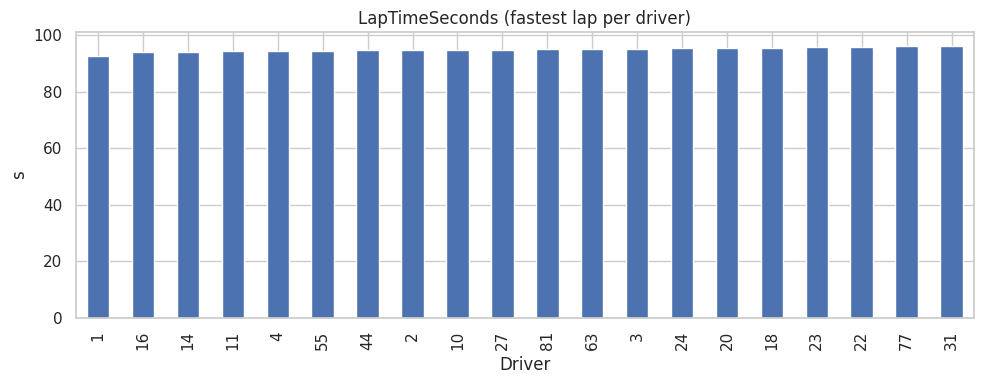

In [454]:
# Distribución de tiempos de vuelta por piloto
lap_summary = meta[['Driver','LapTimeSeconds']].sort_values('LapTimeSeconds')
ax = lap_summary.plot(kind='bar', x='Driver', y='LapTimeSeconds', figsize=(10,4), legend=False, title='LapTimeSeconds (fastest lap per driver)')
ax.set_ylabel('s')
plt.tight_layout()
plt.show()

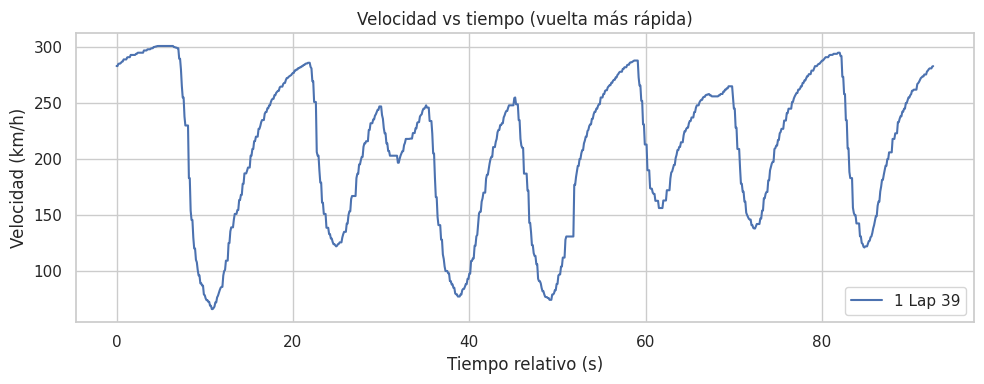

In [455]:
# Velocidad vs tiempo (10 Hz) para el piloto más rápido
fastest = meta.sort_values('LapTimeSeconds').iloc[0]
d = fastest['Driver']; lap = fastest['LapNumber']
sel = telemetry_time[(telemetry_time.Driver == d) & (telemetry_time.LapNumber == lap)]
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sel['RelativeTime_s'], sel['Speed'], label=f"{d} Lap {lap}")
ax.set_xlabel('Tiempo relativo (s)')
ax.set_ylabel('Velocidad (km/h)')
ax.set_title('Velocidad vs tiempo (vuelta más rápida)')
ax.legend()
plt.tight_layout()
plt.show()

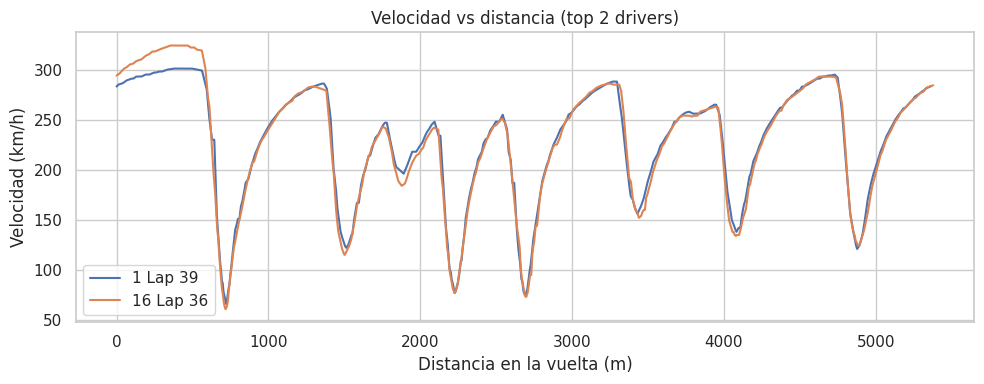

In [456]:
# Velocidad vs distancia (ghost) para los dos más rápidos
top2 = meta.sort_values('LapTimeSeconds').head(2)
fig, ax = plt.subplots(figsize=(10,4))
for _, row in top2.iterrows():
    d = row['Driver']; lap = row['LapNumber']
    sel = telemetry_dist[(telemetry_dist.Driver == d) & (telemetry_dist.LapNumber == lap)]
    ax.plot(sel['Distance_m'], sel['Speed'], label=f"{d} Lap {lap}")
ax.set_xlabel('Distancia en la vuelta (m)')
ax.set_ylabel('Velocidad (km/h)')
ax.set_title('Velocidad vs distancia (top 2 drivers)')
ax.legend()
plt.tight_layout()
plt.show()

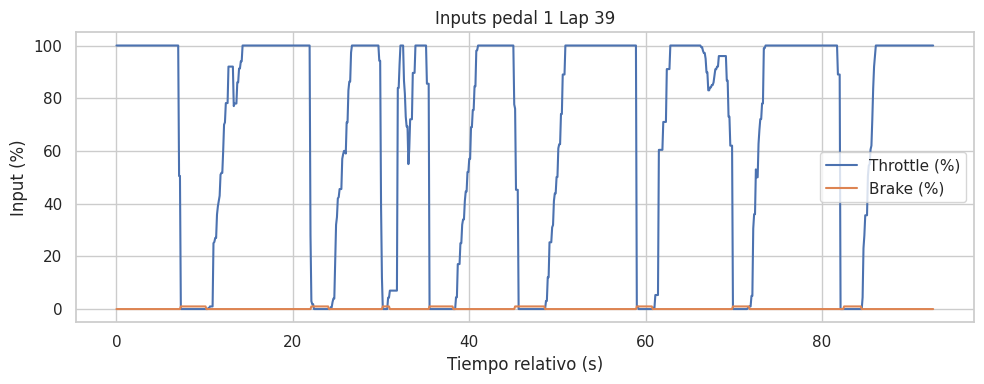

In [457]:
# Relación Throttle/Brake vs tiempo para el piloto más rápido
sel_pedal = telemetry_time[(telemetry_time.Driver == fastest['Driver']) & (telemetry_time.LapNumber == fastest['LapNumber'])]
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sel_pedal['RelativeTime_s'], sel_pedal['Throttle'], label='Throttle (%)')
ax.plot(sel_pedal['RelativeTime_s'], sel_pedal['Brake'], label='Brake (%)')
ax.set_xlabel('Tiempo relativo (s)')
ax.set_ylabel('Input (%)')
ax.set_title(f'Inputs pedal {fastest["Driver"]} Lap {fastest["LapNumber"]}')
ax.legend()
plt.tight_layout()
plt.show()

## Exploración Módulo 2 (dinámicas, jerks, energía)

In [458]:
# Cargar telemetría enriquecida y features por vuelta
enriched = pd.read_csv(f"{base}/telemetry_time_10hz_enriched.csv")
lap_feat = pd.read_csv(f"{base}/lap_features_module2.csv")
print('Shapes -> enriched:', enriched.shape, 'lap_features:', lap_feat.shape)
lap_feat.head()

Shapes -> enriched: (19003, 23) lap_features: (20, 13)


Driver  LapNumber  LapTimeSeconds Compound  TyreLife  Avg_Speed_mps  Avg_Throttle  Brake_Aggression  MeanAbs_Jerk_Long  \
0       1         39          92.608     SOFT         2      57.866350     69.065407          0.391546        3607.637894   
1       2         42          94.735     SOFT         2      56.576900     65.454008          0.390730        3457.147465   
2       3         37          95.163     SOFT         2      56.385182     65.405160          0.395076        3494.733407   
3       4         35          94.476     HARD         2      56.821504     64.499734          0.404128        3508.076008   
4      10         45          94.805     SOFT         2      56.675055     66.537160          0.408801        3566.507057   

   MeanAbs_Jerk_Lat  Max_Lateral_g  Max_Longitudinal_g  Energy_Index  
0        399.999948      86.317673          422.439761  3.464516e+07  
1        359.422811     109.654590          291.621875  3.262333e+07  
2        343.362993      72.325362          664.660862  3.453410e+07  
3        359.348400      68.614629          608.658692  3.400033e+07  
4        366.063718     132.329434          709.336523  3.666045e+07

In [459]:
# Top 5 vueltas por LapTimeSeconds con jerk y energía
cols = ['Driver','LapNumber','LapTimeSeconds','MeanAbs_Jerk_Long','MeanAbs_Jerk_Lat','Energy_Index','Compound','TyreLife']
lap_feat[cols].sort_values('LapTimeSeconds').head()

Driver  LapNumber  LapTimeSeconds  MeanAbs_Jerk_Long  MeanAbs_Jerk_Lat  Energy_Index Compound  TyreLife
0       1         39          92.608        3607.637894        399.999948  3.464516e+07     SOFT         2
7      16         36          94.090        4120.782764        353.353728  4.102412e+07     HARD         2
6      14         48          94.199        3828.621858        389.320101  3.542193e+07     HARD         7
5      11         40          94.364        3645.551081        388.323609  3.528356e+07     SOFT         4
3       4         35          94.476        3508.076008        359.348400  3.400033e+07     HARD         2

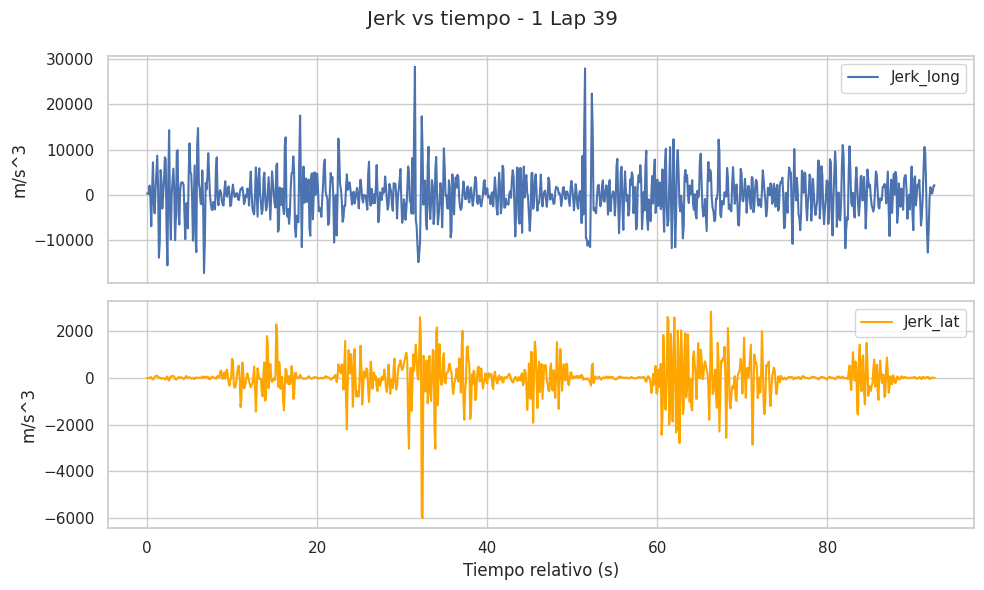

In [460]:
# Jerk longitudinal y lateral vs tiempo para el piloto más rápido
d = fastest['Driver']; lap = fastest['LapNumber']
sel_enr = enriched[(enriched.Driver == d) & (enriched.LapNumber == lap)]
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(sel_enr['RelativeTime_s'], sel_enr['Jerk_long'], label='Jerk_long')
ax[0].set_ylabel('m/s^3')
ax[0].legend()
ax[1].plot(sel_enr['RelativeTime_s'], sel_enr['Jerk_lat'], label='Jerk_lat', color='orange')
ax[1].set_xlabel('Tiempo relativo (s)')
ax[1].set_ylabel('m/s^3')
ax[1].legend()
fig.suptitle(f'Jerk vs tiempo - {d} Lap {lap}')
plt.tight_layout()
plt.show()

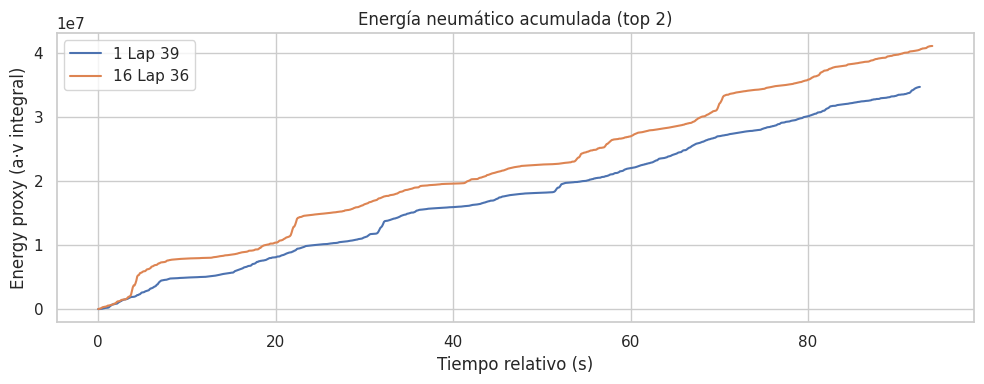

In [461]:
# Evolución del índice de energía de neumático para los dos más rápidos
fig, ax = plt.subplots(figsize=(10,4))
for _, row in top2.iterrows():
    d = row['Driver']; lap = row['LapNumber']
    sel_enr = enriched[(enriched.Driver == d) & (enriched.LapNumber == lap)]
    ax.plot(sel_enr['RelativeTime_s'], sel_enr['TireEnergyProxy'], label=f"{d} Lap {lap}")
ax.set_xlabel('Tiempo relativo (s)')
ax.set_ylabel('Energy proxy (a·v integral)')
ax.set_title('Energía neumático acumulada (top 2)')
ax.legend()
plt.tight_layout()
plt.show()

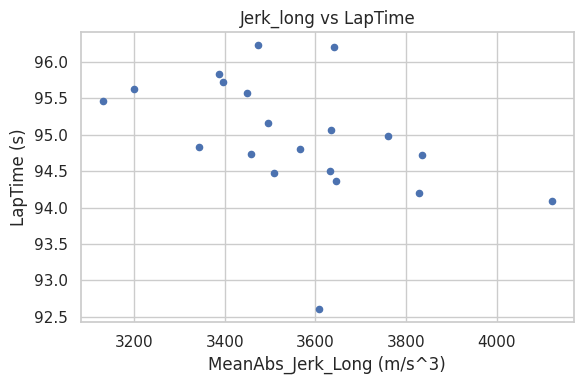

In [462]:
# Dispersión jerk vs lap time (suavidad vs performance)
ax = lap_feat.plot.scatter(x='MeanAbs_Jerk_Long', y='LapTimeSeconds', figsize=(6,4), title='Jerk_long vs LapTime')
ax.set_xlabel('MeanAbs_Jerk_Long (m/s^3)')
ax.set_ylabel('LapTime (s)')
plt.tight_layout()
plt.show()

## EDA estadístico (lap_features_module2)

In [463]:
import numpy as np
from pandas.plotting import scatter_matrix

# Estadísticos básicos
numeric_cols = ['LapTimeSeconds','MeanAbs_Jerk_Long','MeanAbs_Jerk_Lat','Energy_Index','Avg_Speed_mps','Brake_Aggression','Max_Lateral_g','Max_Longitudinal_g']
desc = lap_feat[numeric_cols].describe().T
desc

count          mean           std           min           25%           50%           75%           max
LapTimeSeconds       20.0  9.495975e+01  8.405463e-01  9.260800e+01  9.449925e+01  9.490850e+01  9.558550e+01  9.622600e+01
MeanAbs_Jerk_Long    20.0  3.555643e+03  2.273618e+02  3.132103e+03  3.435646e+03  3.537292e+03  3.641963e+03  4.120783e+03
MeanAbs_Jerk_Lat     20.0  3.622446e+02  2.124177e+01  3.237062e+02  3.452780e+02  3.593856e+02  3.775465e+02  3.999999e+02
Energy_Index         20.0  3.412486e+07  2.606136e+06  3.020911e+07  3.229617e+07  3.458963e+07  3.531816e+07  4.102412e+07
Avg_Speed_mps        20.0  5.649524e+01  5.042597e-01  5.575996e+01  5.611563e+01  5.653812e+01  5.678472e+01  5.786635e+01
Brake_Aggression     20.0  4.046675e-01  8.866030e-03  3.907295e-01  3.990604e-01  4.037319e-01  4.101495e-01  4.192588e-01
Max_Lateral_g        20.0  8.946607e+01  2.452254e+01  6.770664e+01  7.230934e+01  8.037363e+01  9.590261e+01  1.511821e+02
Max_Longitudinal_g   20.0  4.488838e+02  1.689960e+02  2.185402e+02  2.806625e+02  4.667281e+02  5.703867e+02  7.093365e+02

In [464]:
# Correlación de variables con el LapTimeSeconds
corr = lap_feat[numeric_cols].corr()
display(corr)
corr['LapTimeSeconds'].sort_values()

LapTimeSeconds  MeanAbs_Jerk_Long  MeanAbs_Jerk_Lat  Energy_Index  Avg_Speed_mps  Brake_Aggression  Max_Lateral_g  \
LapTimeSeconds            1.000000          -0.464545         -0.635616     -0.461462      -0.991438          0.375835      -0.221996   
MeanAbs_Jerk_Long        -0.464545           1.000000          0.546161      0.928402       0.464275         -0.143368       0.302348   
MeanAbs_Jerk_Lat         -0.635616           0.546161          1.000000      0.465829       0.625773         -0.237049       0.556853   
Energy_Index             -0.461462           0.928402          0.465829      1.000000       0.464978         -0.041335       0.337380   
Avg_Speed_mps            -0.991438           0.464275          0.625773      0.464978       1.000000         -0.382452       0.241144   
Brake_Aggression          0.375835          -0.143368         -0.237049     -0.041335      -0.382452          1.000000       0.033297   
Max_Lateral_g            -0.221996           0.302348          0.556853      0.337380       0.241144          0.033297       1.000000   
Max_Longitudinal_g       -0.266151           0.602519          0.306818      0.789481       0.288610         -0.009509       0.230816   

                    Max_Longitudinal_g  
LapTimeSeconds               -0.266151  
MeanAbs_Jerk_Long             0.602519  
MeanAbs_Jerk_Lat              0.306818  
Energy_Index                  0.789481  
Avg_Speed_mps                 0.288610  
Brake_Aggression             -0.009509  
Max_Lateral_g                 0.230816  
Max_Longitudinal_g            1.000000

Avg_Speed_mps        -0.991438
MeanAbs_Jerk_Lat     -0.635616
MeanAbs_Jerk_Long    -0.464545
Energy_Index         -0.461462
Max_Longitudinal_g   -0.266151
Max_Lateral_g        -0.221996
Brake_Aggression      0.375835
LapTimeSeconds        1.000000
Name: LapTimeSeconds, dtype: float64

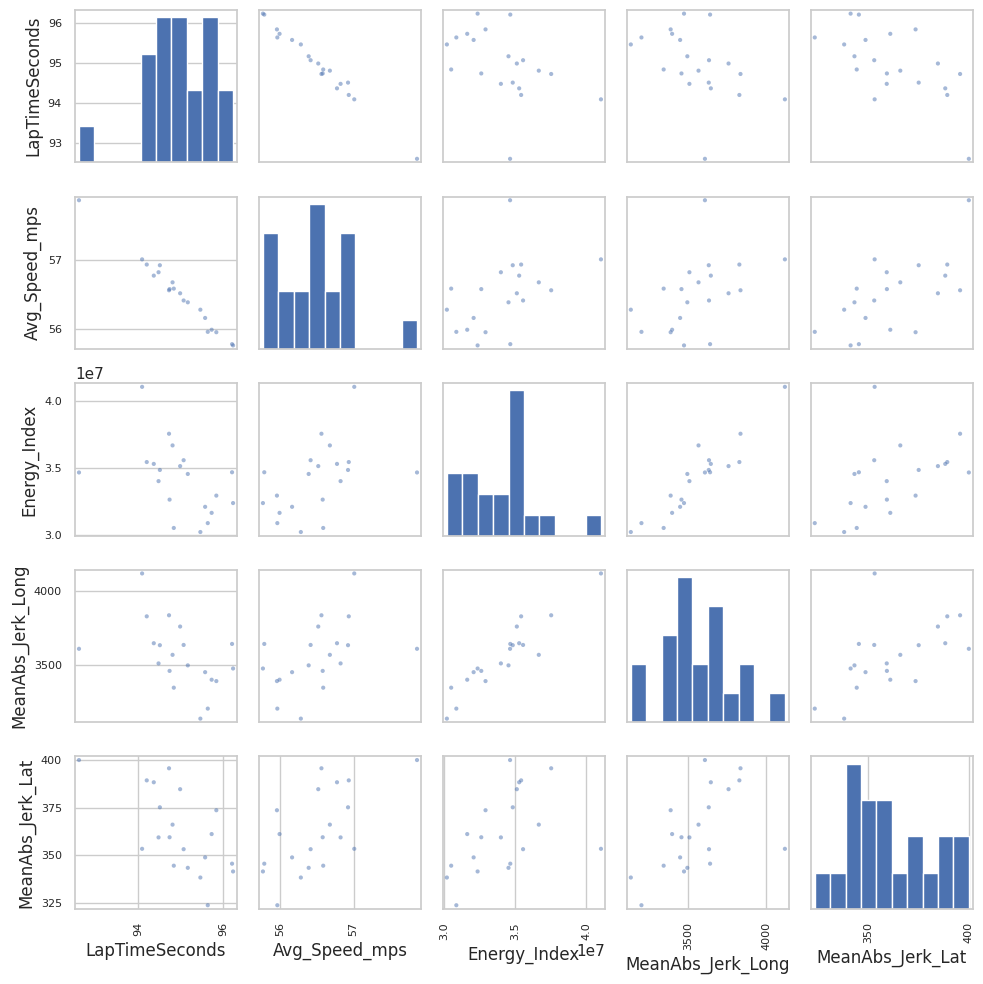

In [465]:
# Scatter matrix reducido para evitar demasiadas combinaciones
scatter_cols = ['LapTimeSeconds','Avg_Speed_mps','Energy_Index','MeanAbs_Jerk_Long','MeanAbs_Jerk_Lat']
axarr = scatter_matrix(lap_feat[scatter_cols], figsize=(10,10), diagonal='hist')
plt.tight_layout()
plt.show()

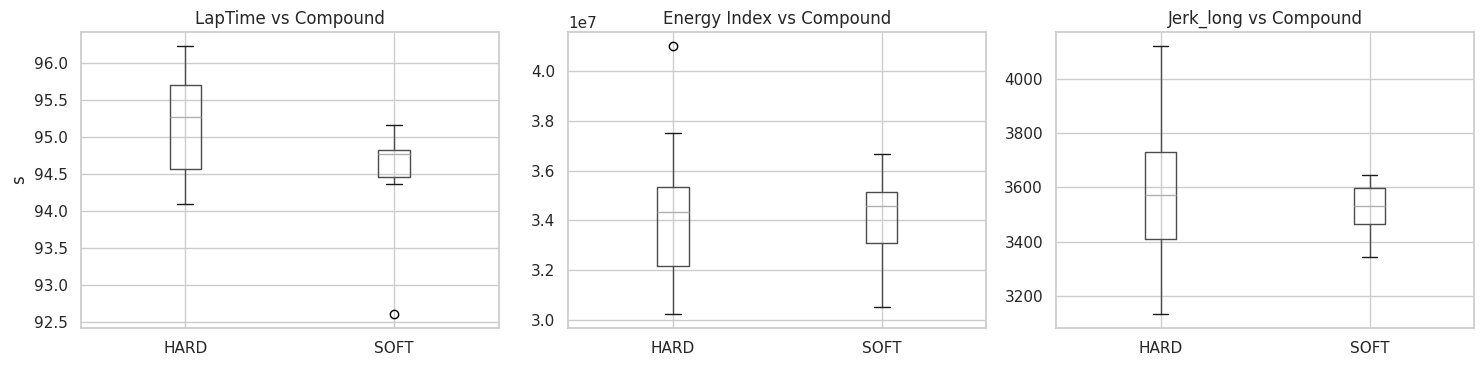

In [466]:
# Distribuciones por compuesto de neumático
fig, ax = plt.subplots(1,3, figsize=(15,4))
lap_feat.boxplot(column='LapTimeSeconds', by='Compound', ax=ax[0])
ax[0].set_title('LapTime vs Compound'); ax[0].set_ylabel('s'); ax[0].set_xlabel('')
lap_feat.boxplot(column='Energy_Index', by='Compound', ax=ax[1])
ax[1].set_title('Energy Index vs Compound'); ax[1].set_xlabel('')
lap_feat.boxplot(column='MeanAbs_Jerk_Long', by='Compound', ax=ax[2])
ax[2].set_title('Jerk_long vs Compound'); ax[2].set_xlabel('')
fig.suptitle(''); plt.tight_layout(); plt.show()

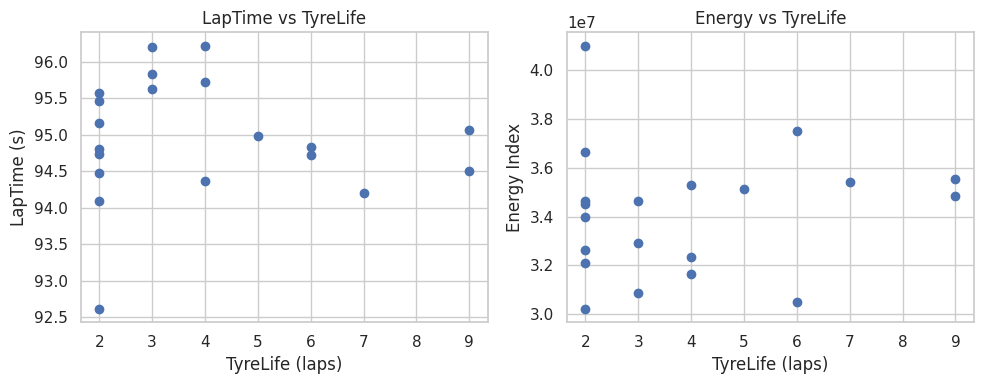

In [467]:
# Relación TyreLife con energía y tiempo de vuelta
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(lap_feat['TyreLife'], lap_feat['LapTimeSeconds'])
ax[0].set_xlabel('TyreLife (laps)'); ax[0].set_ylabel('LapTime (s)'); ax[0].set_title('LapTime vs TyreLife')
ax[1].scatter(lap_feat['TyreLife'], lap_feat['Energy_Index'])
ax[1].set_xlabel('TyreLife (laps)'); ax[1].set_ylabel('Energy Index'); ax[1].set_title('Energy vs TyreLife')
plt.tight_layout(); plt.show()

## Visuales adicionales (EDA enriquecido)

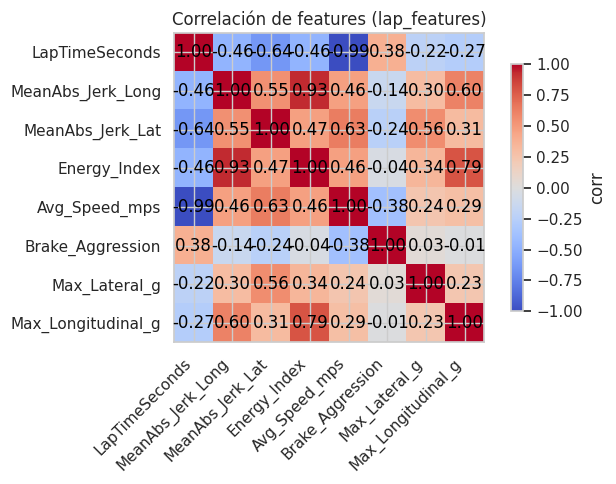

In [468]:
# Heatmap de correlación (lap_features)
import numpy as np
fig, ax = plt.subplots(figsize=(7,5))
corr = lap_feat[numeric_cols].corr()
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', color='black')
fig.colorbar(im, ax=ax, shrink=0.8, label='corr')
ax.set_title('Correlación de features (lap_features)')
plt.tight_layout(); plt.show()

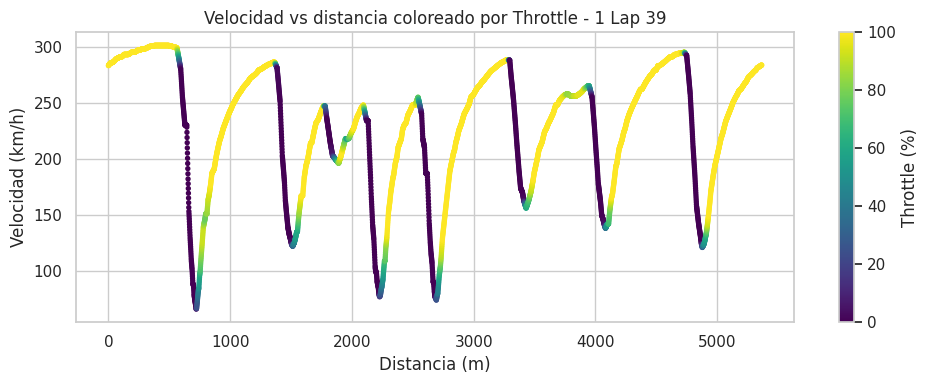

In [469]:
# Perfil de velocidad vs distancia con color por throttle (vuelta más rápida)
sel_dist = telemetry_dist[(telemetry_dist.Driver == fastest['Driver']) & (telemetry_dist.LapNumber == fastest['LapNumber'])]
fig, ax = plt.subplots(figsize=(10,4))
sc = ax.scatter(sel_dist['Distance_m'], sel_dist['Speed'], c=sel_dist['Throttle'], cmap='viridis', s=8)
ax.set_xlabel('Distancia (m)'); ax.set_ylabel('Velocidad (km/h)');
ax.set_title(f'Velocidad vs distancia coloreado por Throttle - {fastest["Driver"]} Lap {fastest["LapNumber"]}')
cbar = plt.colorbar(sc, ax=ax); cbar.set_label('Throttle (%)')
plt.tight_layout(); plt.show()

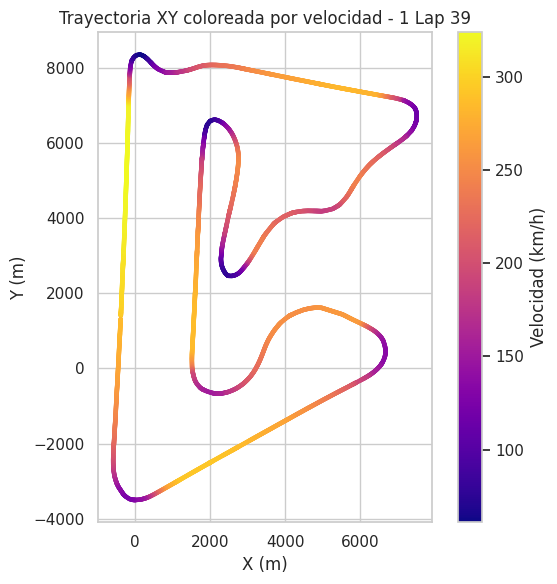

In [470]:
# Mapa XY coloreado por velocidad (vuelta más rápida)
fig, ax = plt.subplots(figsize=(6,6))
sc = ax.scatter(sel['X'], sel['Y'], c=sel['Speed'], cmap='plasma', s=5)
ax.set_aspect('equal', 'box')
ax.set_title(f'Trayectoria XY coloreada por velocidad - {fastest["Driver"]} Lap {fastest["LapNumber"]}')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
cbar = plt.colorbar(sc, ax=ax); cbar.set_label('Velocidad (km/h)')
plt.tight_layout(); plt.show()

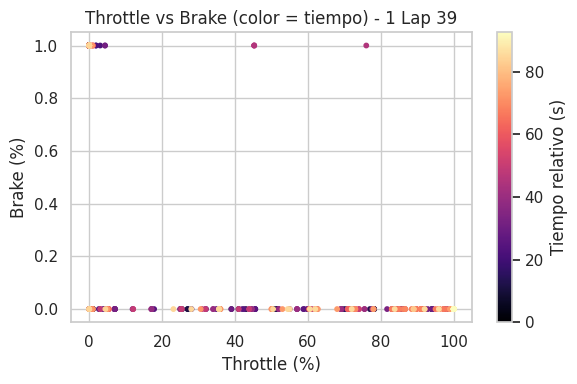

In [471]:
# Throttle vs Brake coloreado por tiempo (vuelta más rápida)
fig, ax = plt.subplots(figsize=(6,4))
sc = ax.scatter(sel_pedal['Throttle'], sel_pedal['Brake'], c=sel_pedal['RelativeTime_s'], cmap='magma', s=10)
ax.set_xlabel('Throttle (%)'); ax.set_ylabel('Brake (%)')
ax.set_title(f'Throttle vs Brake (color = tiempo) - {fastest["Driver"]} Lap {fastest["LapNumber"]}')
cbar = plt.colorbar(sc, ax=ax); cbar.set_label('Tiempo relativo (s)')
plt.tight_layout(); plt.show()

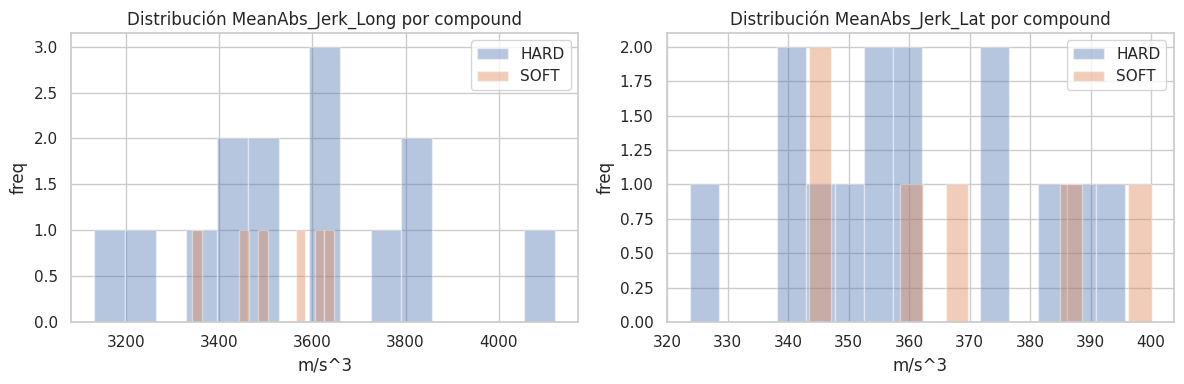

In [472]:
# Distribución de jerk por compuesto
fig, ax = plt.subplots(1,2, figsize=(12,4))
for comp, data in lap_feat.groupby('Compound'):
    ax[0].hist(data['MeanAbs_Jerk_Long'].dropna(), bins=15, alpha=0.4, label=comp)
    ax[1].hist(data['MeanAbs_Jerk_Lat'].dropna(), bins=15, alpha=0.4, label=comp)
ax[0].set_title('Distribución MeanAbs_Jerk_Long por compound'); ax[0].set_xlabel('m/s^3'); ax[0].set_ylabel('freq')
ax[1].set_title('Distribución MeanAbs_Jerk_Lat por compound'); ax[1].set_xlabel('m/s^3'); ax[1].set_ylabel('freq')
ax[0].legend(); ax[1].legend()
plt.tight_layout(); plt.show()

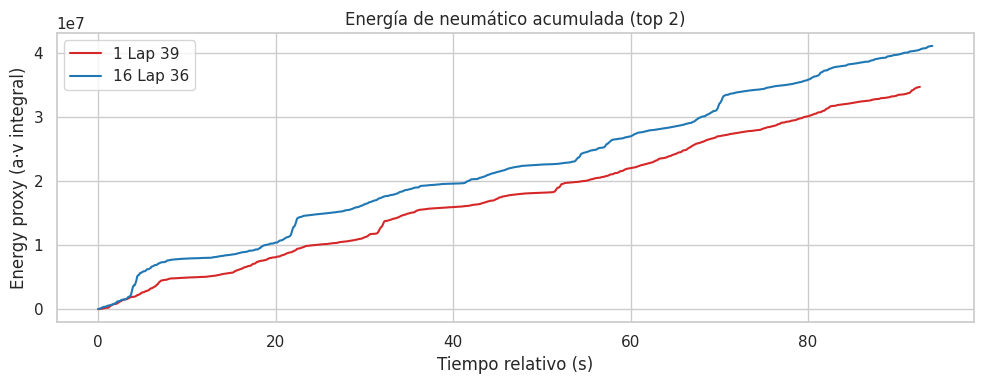

In [473]:
# Energy proxy a lo largo del tiempo para top 2 (color por piloto)
fig, ax = plt.subplots(figsize=(10,4))
colors = ['tab:red','tab:blue']
for (idx, row), color in zip(top2.iterrows(), colors):
    d = row['Driver']; lap = row['LapNumber']
    sel_enr = enriched[(enriched.Driver == d) & (enriched.LapNumber == lap)]
    ax.plot(sel_enr['RelativeTime_s'], sel_enr['TireEnergyProxy'], color=color, label=f"{d} Lap {lap}")
ax.set_xlabel('Tiempo relativo (s)'); ax.set_ylabel('Energy proxy (a·v integral)')
ax.set_title('Energía de neumático acumulada (top 2)')
ax.legend(); plt.tight_layout(); plt.show()

## PCA (Módulo 3)

In [474]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Construir matriz de features (similar a module3_pca.py)
feat_cols = ['LapTimeSeconds','Energy_Index','MeanAbs_Jerk_Long','MeanAbs_Jerk_Lat','Avg_Speed_mps','Brake_Aggression','Max_Lateral_g','Max_Longitudinal_g','TyreLife']
compound_dummies = pd.get_dummies(lap_feat['Compound'], prefix='Compound')
X = pd.concat([lap_feat[feat_cols], compound_dummies], axis=1)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=3, random_state=42)
scores = pca.fit_transform(Xs)
scores_df = pd.DataFrame(scores, columns=['PC1','PC2','PC3'])
pca.explained_variance_ratio_


array([0.38860614, 0.22374291, 0.12180328])

In [475]:
# Varianza explicada
var_ratio = pca.explained_variance_ratio_
print('Explained variance ratio:', var_ratio)

Explained variance ratio: [0.38860614 0.22374291 0.12180328]


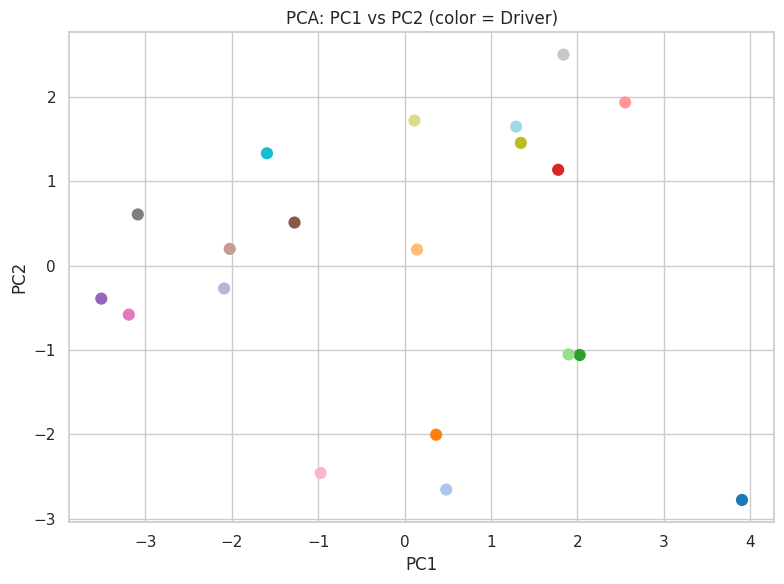

In [476]:
# Scatter PC1 vs PC2 coloreado por piloto
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(scores_df['PC1'], scores_df['PC2'], c=pd.factorize(lap_feat['Driver'])[0], cmap='tab20', s=60)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_title('PCA: PC1 vs PC2 (color = Driver)')
plt.tight_layout(); plt.show()

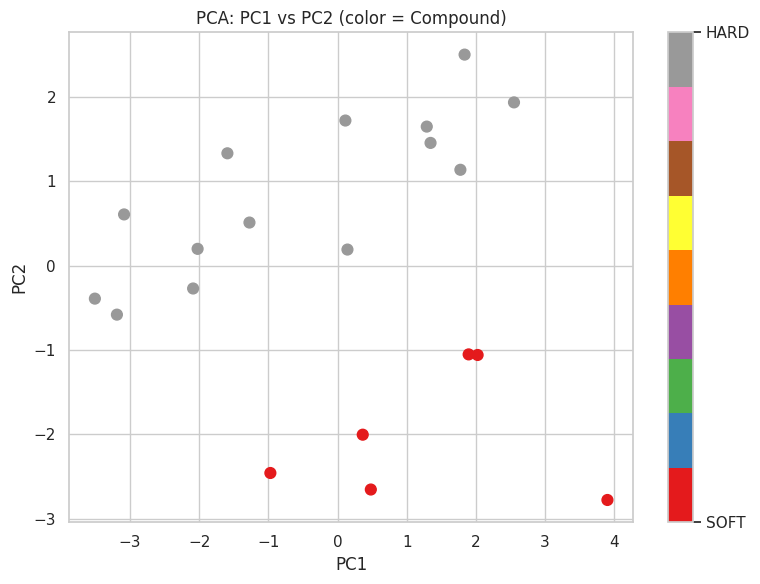

In [477]:
# Scatter PC1 vs PC2 coloreado por compuesto
fig, ax = plt.subplots(figsize=(8,6))
comp_codes, comp_uniques = pd.factorize(lap_feat['Compound'])
sc = ax.scatter(scores_df['PC1'], scores_df['PC2'], c=comp_codes, cmap='Set1', s=60)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_title('PCA: PC1 vs PC2 (color = Compound)')
cbar = plt.colorbar(sc, ax=ax, ticks=range(len(comp_uniques)))
cbar.ax.set_yticklabels(comp_uniques)
plt.tight_layout(); plt.show()

In [478]:
# Loadings (contribución de cada feature a PC1/PC2)
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=['PC1','PC2','PC3'])
loadings[['PC1','PC2']].sort_values('PC1', key=lambda s: s.abs(), ascending=False).head(10)

PC1       PC2
Avg_Speed_mps       0.414705 -0.150056
LapTimeSeconds     -0.413415  0.160057
MeanAbs_Jerk_Lat    0.375044  0.091051
Energy_Index        0.369229  0.302354
MeanAbs_Jerk_Long   0.359953  0.338748
Max_Longitudinal_g  0.292434  0.173277
Max_Lateral_g       0.233752  0.121592
Compound_HARD      -0.196651  0.532303
Compound_SOFT       0.196651 -0.532303
Brake_Aggression   -0.167645  0.181872

## PCA (artefactos guardados del Módulo 3)

In [479]:
# Cargar scores y modelo guardados
import json
base_path = base  # reutiliza variable base definida arriba
pca_scores = pd.read_csv(f"{base_path}/pca_scores_module3.csv")
pca_model = json.loads(open(f"{base_path}/pca_model_module3.json").read())
variance = pca_model['explained_variance_ratio']
feature_names = pca_model['feature_names']
print('variance ratio:', variance)
pca_scores.head()

variance ratio: [0.38860613725439924, 0.22374291458483173, 0.12180327632095644]


Driver  LapNumber Compound       PC1       PC2       PC3
0       1         39     SOFT  3.904785 -2.778684 -1.077396
1       2         42     SOFT  0.481914 -2.654687 -0.583961
2       3         37     SOFT  0.364939 -2.004267  1.736408
3       4         35     HARD  0.143842  0.191345  0.710557
4      10         45     SOFT  2.026942 -1.058963  1.700564

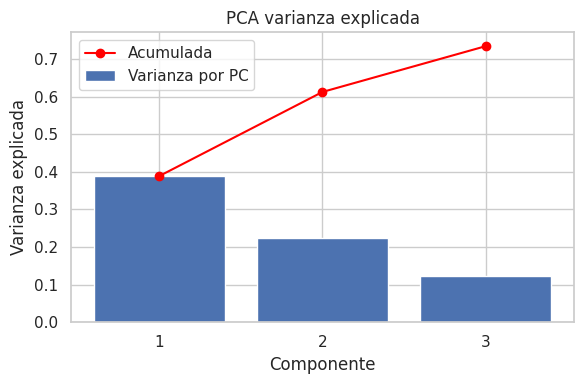

In [480]:
# Varianza explicada (barras + acumulada)
import numpy as np
var = np.array(variance)
cum = var.cumsum()
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(range(1, len(var)+1), var, label='Varianza por PC')
ax.plot(range(1, len(cum)+1), cum, marker='o', color='red', label='Acumulada')
ax.set_xlabel('Componente'); ax.set_ylabel('Varianza explicada'); ax.set_title('PCA varianza explicada')
ax.set_xticks(range(1, len(var)+1))
ax.legend(); plt.tight_layout(); plt.show()

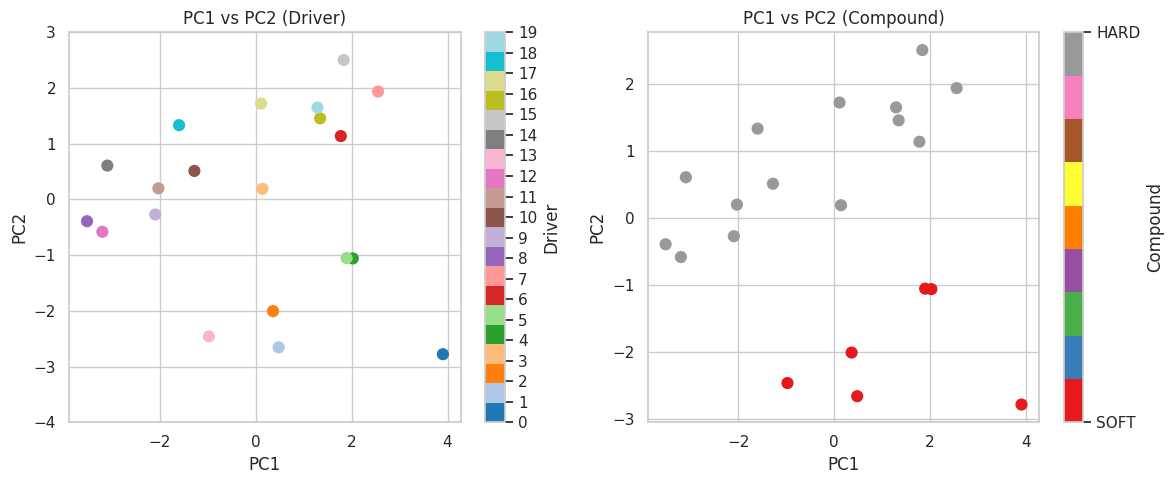

In [481]:
# Scatter PC1 vs PC2 coloreado por piloto y por compuesto
fig, ax = plt.subplots(1,2, figsize=(12,5))
driver_codes, driver_labels = pd.factorize(pca_scores['Driver'])
sc1 = ax[0].scatter(pca_scores['PC1'], pca_scores['PC2'], c=driver_codes, cmap='tab20', s=60)
ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2'); ax[0].set_title('PC1 vs PC2 (Driver)')
plt.colorbar(sc1, ax=ax[0], ticks=range(len(driver_labels)), label='Driver')
ax[0].set_yticks(ax[0].get_yticks())
comp_codes, comp_labels = pd.factorize(pca_scores['Compound'])
sc2 = ax[1].scatter(pca_scores['PC1'], pca_scores['PC2'], c=comp_codes, cmap='Set1', s=60)
ax[1].set_xlabel('PC1'); ax[1].set_ylabel('PC2'); ax[1].set_title('PC1 vs PC2 (Compound)')
plt.colorbar(sc2, ax=ax[1], ticks=range(len(comp_labels)), label='Compound').ax.set_yticklabels(comp_labels)
plt.tight_layout(); plt.show()

In [482]:
# Loadings (contribución de cada feature a PC1/PC2) ordenadas por magnitud
import pandas as pd
loadings = pd.DataFrame(pca_model['components']).T
loadings.index = feature_names
loadings.columns = [f'PC{i+1}' for i in range(loadings.shape[1])]
load_pc12 = loadings[['PC1','PC2']].copy()
load_pc12['abs_PC1'] = load_pc12['PC1'].abs()
load_pc12_sorted = load_pc12.sort_values('abs_PC1', ascending=False).drop(columns=['abs_PC1'])
load_pc12_sorted.head(10)

PC1       PC2
Avg_Speed_mps       0.414705 -0.150056
LapTimeSeconds     -0.413415  0.160057
MeanAbs_Jerk_Lat    0.375044  0.091051
Energy_Index        0.369229  0.302354
MeanAbs_Jerk_Long   0.359953  0.338748
Max_Longitudinal_g  0.292434  0.173277
Max_Lateral_g       0.233752  0.121592
Compound_HARD      -0.196651  0.532303
Compound_SOFT       0.196651 -0.532303
Brake_Aggression   -0.167645  0.181872

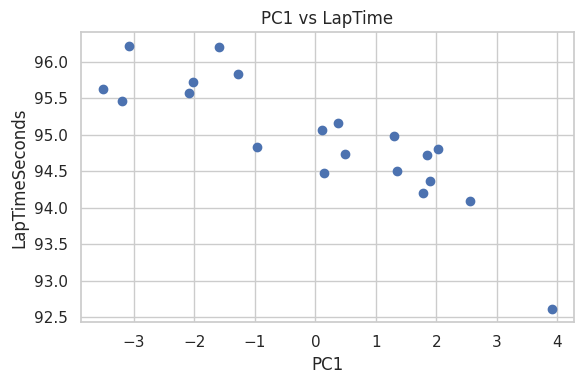

In [483]:
# PC1 vs LapTimeSeconds (para ver si PC1 captura ritmo)
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(pca_scores['PC1'], lap_feat['LapTimeSeconds'])
ax.set_xlabel('PC1'); ax.set_ylabel('LapTimeSeconds'); ax.set_title('PC1 vs LapTime')
plt.tight_layout(); plt.show()

## PCA avanzado: elipse de confianza, ejes y biplots

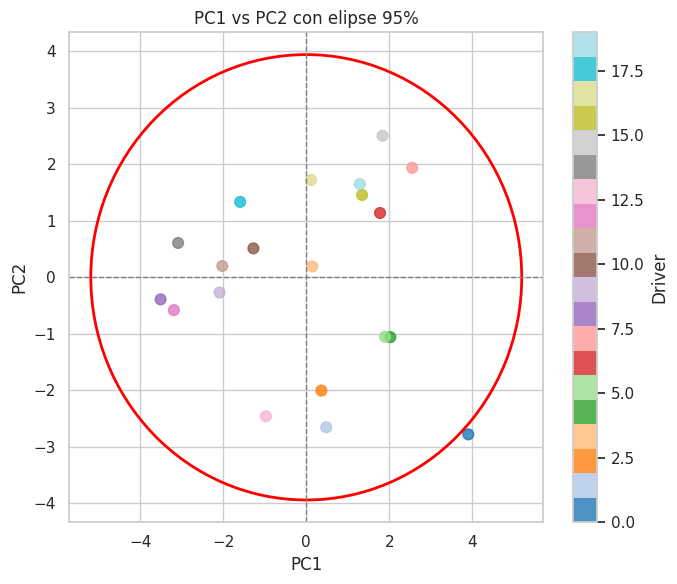

In [484]:
# Scatter PC1 vs PC2 con ejes cruz y elipse de confianza (95%)
import numpy as np
from matplotlib.patches import Ellipse

pc1 = pca_scores['PC1']; pc2 = pca_scores['PC2']
fig, ax = plt.subplots(figsize=(7,6))
# Ejes cruzados en (0,0)
ax.axhline(0, color='gray', linewidth=1, linestyle='--')
ax.axvline(0, color='gray', linewidth=1, linestyle='--')
sc = ax.scatter(pc1, pc2, c=pd.factorize(pca_scores['Driver'])[0], cmap='tab20', s=60, alpha=0.8)
# Elipse de confianza
mu = np.array([pc1.mean(), pc2.mean()])
cov = np.cov(pc1, pc2)
vals, vecs = np.linalg.eigh(cov)
order = vals.argsort()[::-1]; vals = vals[order]; vecs = vecs[:, order]
chi2_val = 5.991  # chi2(2, 95%)
width = 2 * np.sqrt(vals[0] * chi2_val)
height = 2 * np.sqrt(vals[1] * chi2_val)
angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
ellipse = Ellipse(xy=mu, width=width, height=height, angle=angle, edgecolor='red', facecolor='none', lw=2)
ax.add_patch(ellipse)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_title('PC1 vs PC2 con elipse 95%')
plt.colorbar(sc, ax=ax, label='Driver'); plt.tight_layout(); plt.show()

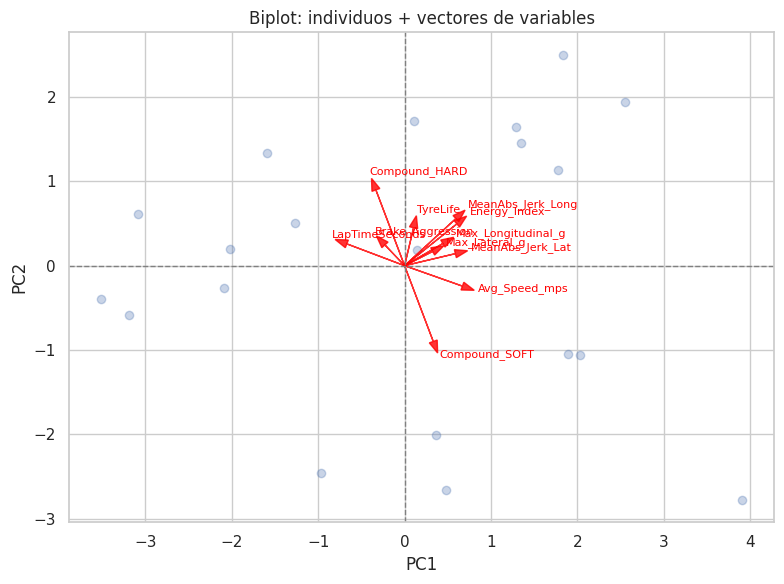

In [485]:
# Biplot PC1/PC2: individuos + vectores de variables
import numpy as np
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pc1, pc2, alpha=0.3, label='Laps')
load_df = pd.DataFrame(pca_model['components']).T
load_df.index = pca_model['feature_names']
load_df.columns = [f'PC{i+1}' for i in range(load_df.shape[1])]
scale = 0.7 * min(pc1.abs().max(), pc2.abs().max())
for feat in load_df.index:
    xvec = load_df.loc[feat, 'PC1'] * scale
    yvec = load_df.loc[feat, 'PC2'] * scale
    ax.arrow(0, 0, xvec, yvec, color='red', head_width=0.05*scale, length_includes_head=True, alpha=0.8)
    ax.text(xvec*1.05, yvec*1.05, feat, color='red', fontsize=8)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_title('Biplot: individuos + vectores de variables')
plt.tight_layout(); plt.show()

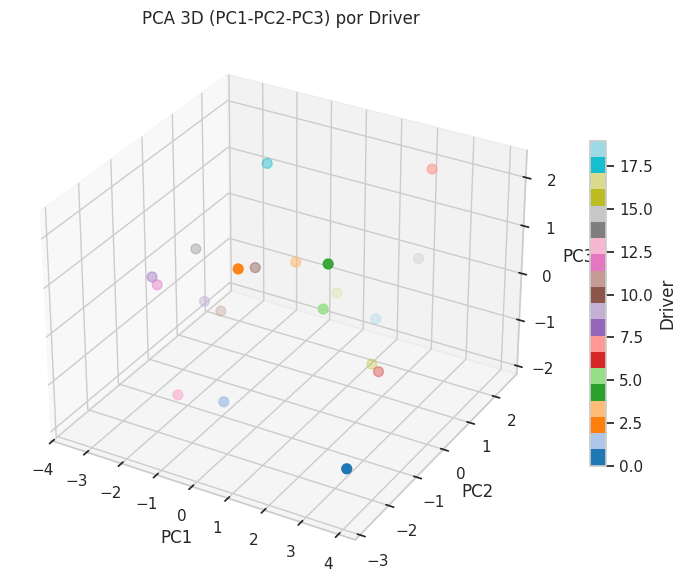

In [486]:
# Scatter 3D PC1-PC2-PC3 coloreado por piloto
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
driver_codes, driver_labels = pd.factorize(pca_scores['Driver'])
sc = ax.scatter(pca_scores['PC1'], pca_scores['PC2'], pca_scores['PC3'], c=driver_codes, cmap='tab20', s=50)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.set_title('PCA 3D (PC1-PC2-PC3) por Driver')
fig.colorbar(sc, ax=ax, shrink=0.6, label='Driver')
plt.tight_layout(); plt.show()

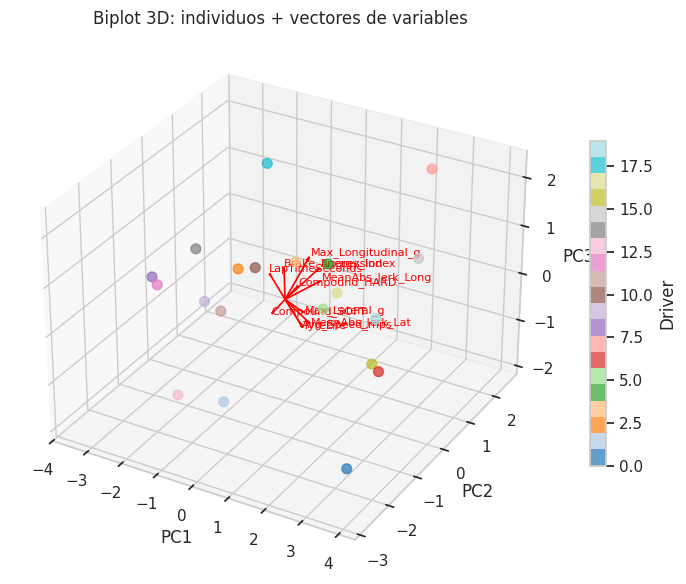

In [487]:
# Biplot 3D: individuos + vectores de variables en PC1/PC2/PC3
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# individuos
sc = ax.scatter(pca_scores['PC1'], pca_scores['PC2'], pca_scores['PC3'], c=pd.factorize(pca_scores['Driver'])[0], cmap='tab20', s=50, alpha=0.7)
# vectores (loadings)
load_df = pd.DataFrame(pca_model['components']).T
load_df.index = pca_model['feature_names']
load_df.columns = [f'PC{i+1}' for i in range(load_df.shape[1])]
scale = 0.7 * min(pca_scores['PC1'].abs().max(), pca_scores['PC2'].abs().max(), pca_scores['PC3'].abs().max())
for feat in load_df.index:
    xvec = load_df.loc[feat, 'PC1'] * scale
    yvec = load_df.loc[feat, 'PC2'] * scale
    zvec = load_df.loc[feat, 'PC3'] * scale
    ax.quiver(0, 0, 0, xvec, yvec, zvec, color='red', arrow_length_ratio=0.1, linewidth=1.2)
    ax.text(xvec*1.05, yvec*1.05, zvec*1.05, feat, color='red', fontsize=8)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.set_title('Biplot 3D: individuos + vectores de variables')
fig.colorbar(sc, ax=ax, shrink=0.6, label='Driver')
plt.tight_layout(); plt.show()

## Módulo 4: Modelado (métricas y visualizaciones)

In [488]:
import json
metrics_path = f"{base}/model_metrics_module4.json"
preds_path = f"{base}/val_predictions_module4.csv"
metrics = json.loads(open(metrics_path).read())
preds = pd.read_csv(preds_path)
metrics_for_df = {k:v for k,v in metrics.items() if k != 'best_model'}
display(pd.DataFrame(metrics_for_df).T)
preds.head()

MAE      RMSE        R2
RandomForest      0.504447  0.930468  0.092048
GradientBoosting  0.568287  0.897282  0.155660
Lasso             0.161946  0.182602  0.965032

y_true     y_pred
0  92.608  92.915579
1  95.065  95.170421
2  94.722  94.846257
3  94.735  94.845528

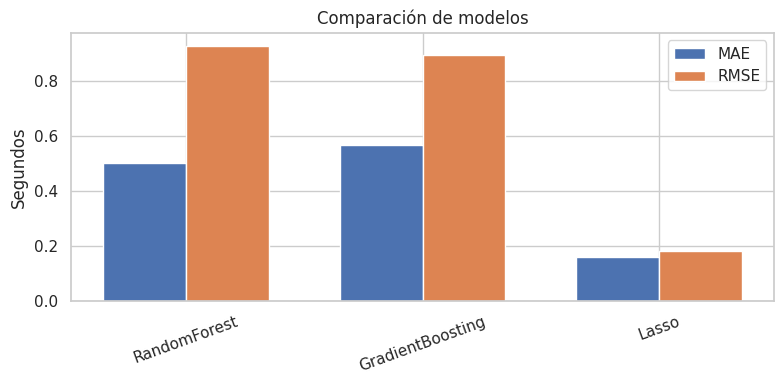

In [489]:
import numpy as np
import matplotlib.pyplot as plt
metrics_for_df = {k:v for k,v in metrics.items() if k != 'best_model'}
model_names = list(metrics_for_df.keys())
mae_vals = [metrics_for_df[m].get('MAE_mean', metrics_for_df[m].get('MAE', 0)) for m in model_names]
rmse_vals = [metrics_for_df[m].get('RMSE_mean', metrics_for_df[m].get('RMSE', 0)) for m in model_names]
x = np.arange(len(model_names))
width = 0.35
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - width/2, mae_vals, width, label='MAE')
ax.bar(x + width/2, rmse_vals, width, label='RMSE')
ax.set_xticks(x); ax.set_xticklabels(model_names, rotation=20)
ax.set_ylabel('Segundos'); ax.set_title('Comparación de modelos')
ax.legend(); plt.tight_layout(); plt.show()

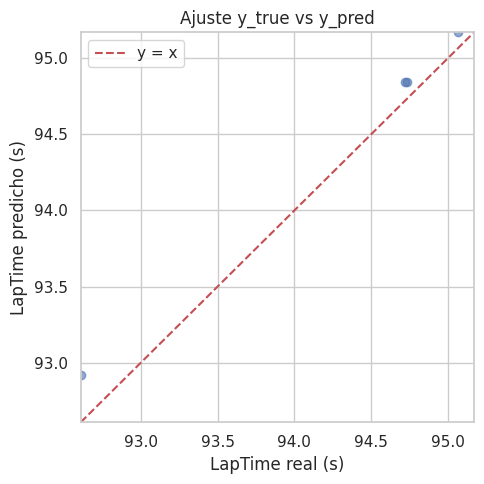

In [490]:
# y_true vs y_pred del mejor modelo
import matplotlib.pyplot as plt
import numpy as np
# Suponemos que 'preds' ya está cargado en el entorno (ver celdas anteriores)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(preds['y_true'], preds['y_pred'], alpha=0.6)
lims = [
    float(min(preds['y_true'].min(), preds['y_pred'].min())),
    float(max(preds['y_true'].max(), preds['y_pred'].max()))
]
ax.plot(lims, lims, 'r--', label='y = x')
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel('LapTime real (s)'); ax.set_ylabel('LapTime predicho (s)')
ax.legend(); ax.set_title('Ajuste y_true vs y_pred')
plt.tight_layout(); plt.show()


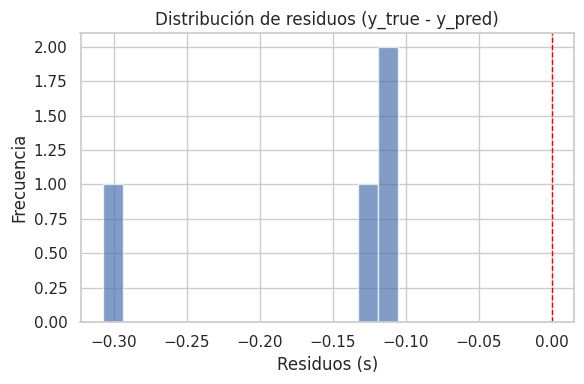

In [491]:
# Distribución de residuos
residuals = preds['y_true'] - preds['y_pred']
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(residuals, bins=15, alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=1)
ax.set_title('Distribución de residuos (y_true - y_pred)')
ax.set_xlabel('Residuos (s)'); ax.set_ylabel('Frecuencia')
plt.tight_layout(); plt.show()

## EDA multiaño (all_lap_features.csv)

In [492]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_df = pd.read_csv('../feature_extraction/data/module1_ingestion/all_lap_features.csv')
print('shape', all_df.shape)
print(all_df.groupby('Year').size())
all_df.head()

shape (1719, 16)
Year
2021    403
2022    426
2023    427
2024    463
dtype: int64


Driver  LapNumber  LapTimeSeconds Compound  TyreLife  Avg_Speed_mps  Avg_Throttle  Brake_Aggression  MeanAbs_Jerk_Long  \
0       1         56          87.765     HARD      27.0      59.691856     67.427988          0.356491        3724.862008   
1       4         52          87.438     HARD      26.0      59.549224     66.022638          0.352446        3787.153473   
2      10         30          89.251     HARD      16.0      58.501401     70.297147          0.344818        3465.595521   
3      14         51          87.948     HARD      15.0      59.269282     63.188239          0.368075        3830.513642   
4      16         51          88.018     HARD      31.0      59.259854     71.600456          0.369986        3788.356424   

   MeanAbs_Jerk_Lat  Max_Lateral_g  Max_Longitudinal_g  Energy_Index  Year                 Event SessionType  
0        509.710210     208.643351          425.452048  3.542106e+07  2024  Abu_Dhabi_Grand_Prix           R  
1        522.932571     294.196370          614.741784  3.757495e+07  2024  Abu_Dhabi_Grand_Prix           R  
2        435.651577      97.628887          385.905555  3.406765e+07  2024  Abu_Dhabi_Grand_Prix           R  
3        484.793492     138.679008          264.940395  3.580297e+07  2024  Abu_Dhabi_Grand_Prix           R  
4        505.835864     104.497668          330.602827  3.595736e+07  2024  Abu_Dhabi_Grand_Prix           R

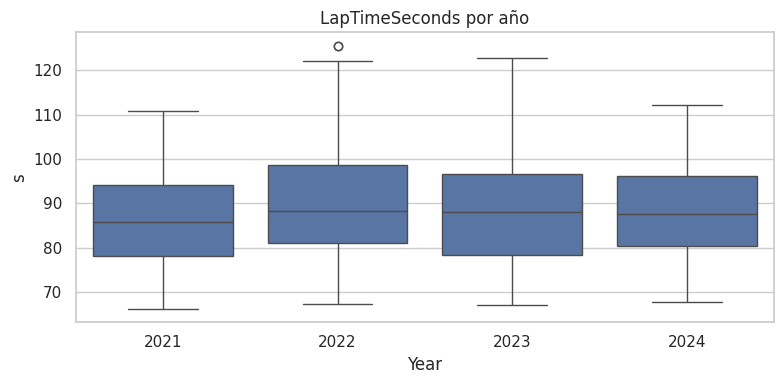

In [493]:
# Distribución de LapTime por año
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=all_df, x='Year', y='LapTimeSeconds', ax=ax)
ax.set_title('LapTimeSeconds por año'); ax.set_ylabel('s')
plt.tight_layout(); plt.show()

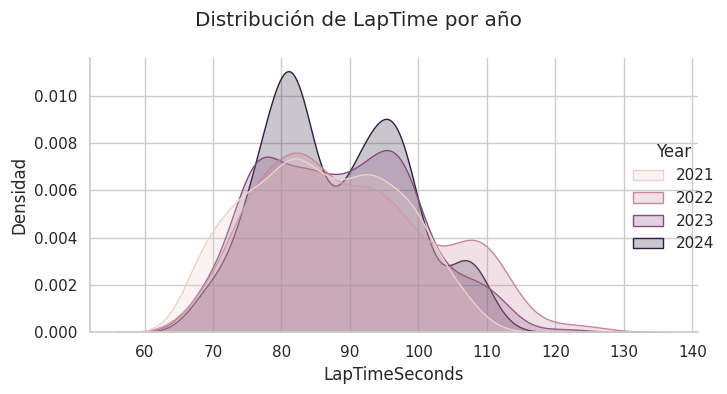

In [494]:
# Histograma de LapTime con KDE por año
g = sns.displot(data=all_df, x='LapTimeSeconds', hue='Year', kind='kde', fill=True, height=4, aspect=1.6)
g.set_axis_labels('LapTimeSeconds', 'Densidad'); g.fig.suptitle('Distribución de LapTime por año')
plt.tight_layout(); plt.show()

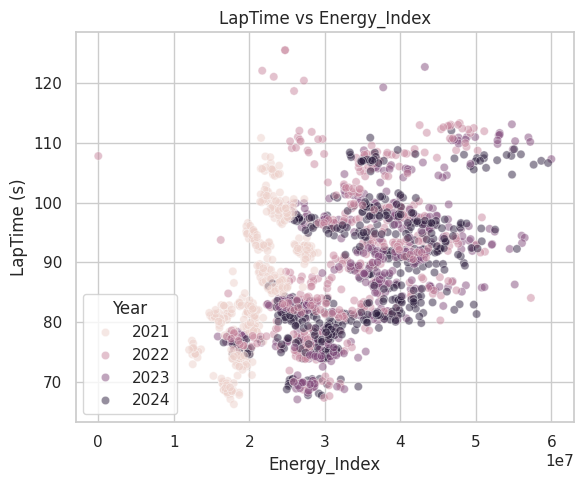

In [495]:
# Scatter LapTime vs Energy_Index coloreado por año
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data=all_df, x='Energy_Index', y='LapTimeSeconds', hue='Year', alpha=0.5, ax=ax)
ax.set_title('LapTime vs Energy_Index'); ax.set_ylabel('LapTime (s)'); ax.set_xlabel('Energy_Index')
plt.tight_layout(); plt.show()

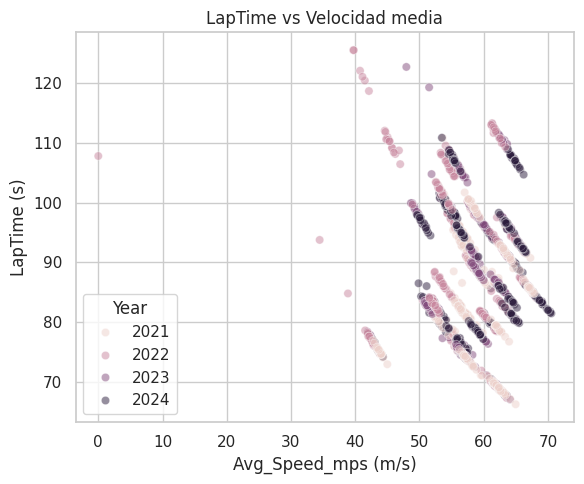

In [496]:
# Scatter Avg_Speed_mps vs LapTime
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data=all_df, x='Avg_Speed_mps', y='LapTimeSeconds', hue='Year', alpha=0.5, ax=ax)
ax.set_title('LapTime vs Velocidad media'); ax.set_ylabel('LapTime (s)'); ax.set_xlabel('Avg_Speed_mps (m/s)')
plt.tight_layout(); plt.show()

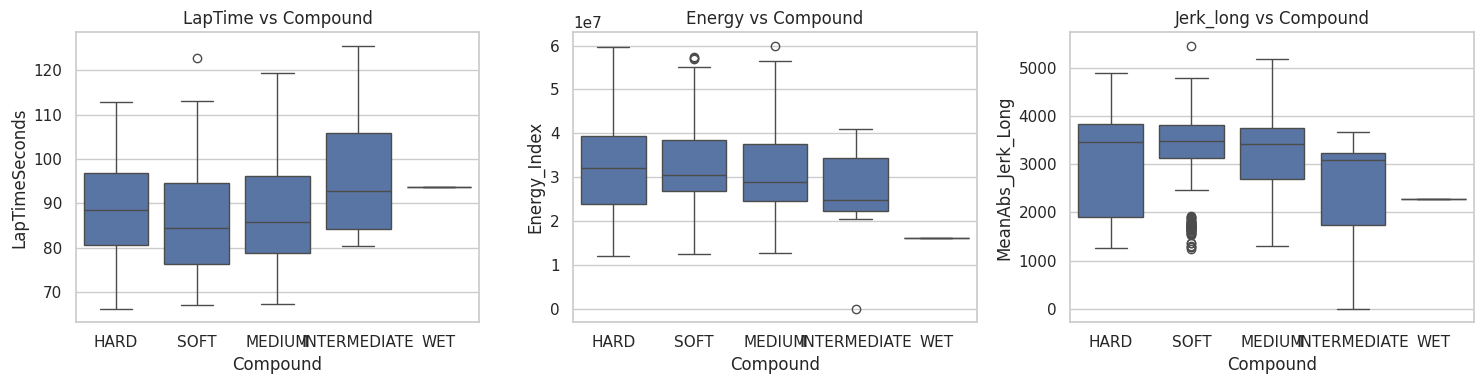

In [497]:
# Boxplots por Compound
fig, ax = plt.subplots(1,3, figsize=(15,4))
sns.boxplot(data=all_df, x='Compound', y='LapTimeSeconds', ax=ax[0])
sns.boxplot(data=all_df, x='Compound', y='Energy_Index', ax=ax[1])
sns.boxplot(data=all_df, x='Compound', y='MeanAbs_Jerk_Long', ax=ax[2])
ax[0].set_title('LapTime vs Compound'); ax[1].set_title('Energy vs Compound'); ax[2].set_title('Jerk_long vs Compound')
plt.tight_layout(); plt.show()

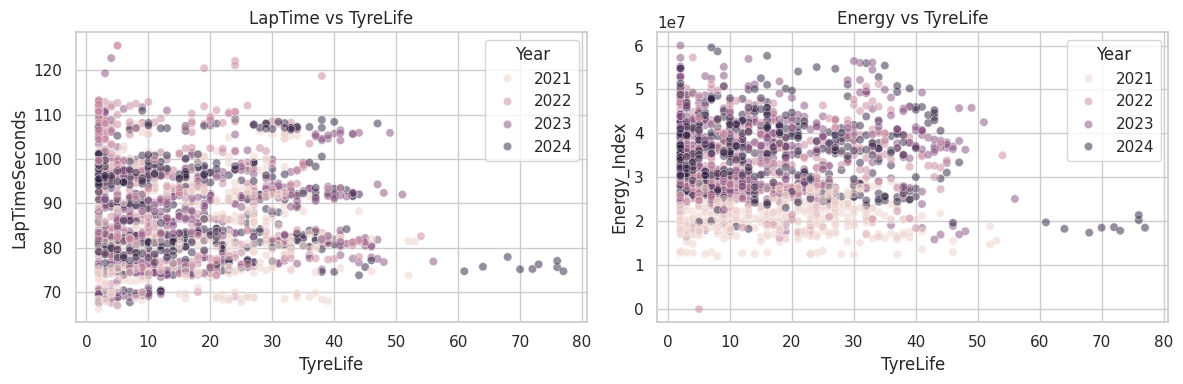

In [498]:
# Scatter TyreLife vs LapTime y TyreLife vs Energy
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.scatterplot(data=all_df, x='TyreLife', y='LapTimeSeconds', hue='Year', alpha=0.5, ax=ax[0])
sns.scatterplot(data=all_df, x='TyreLife', y='Energy_Index', hue='Year', alpha=0.5, ax=ax[1])
ax[0].set_title('LapTime vs TyreLife'); ax[1].set_title('Energy vs TyreLife')
plt.tight_layout(); plt.show()

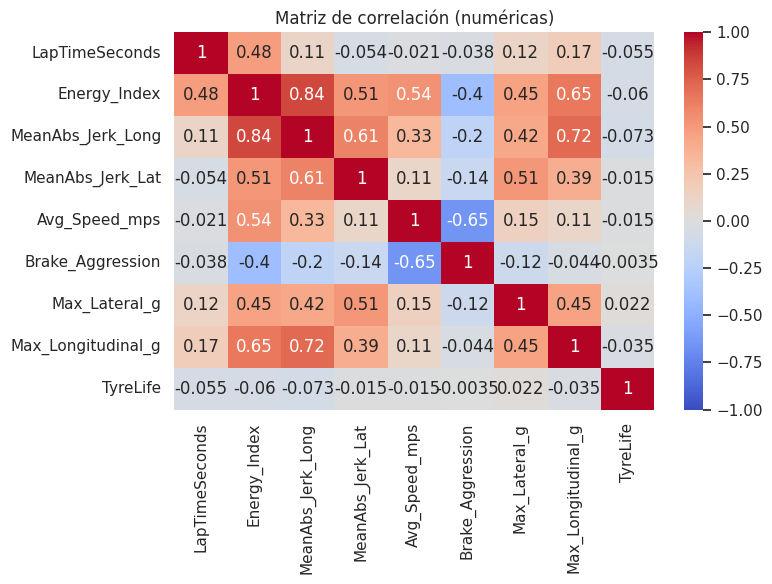

In [499]:
# Correlación de variables numéricas (heatmap)
num_cols = ['LapTimeSeconds','Energy_Index','MeanAbs_Jerk_Long','MeanAbs_Jerk_Lat','Avg_Speed_mps','Brake_Aggression','Max_Lateral_g','Max_Longitudinal_g','TyreLife']
corr = all_df[num_cols].corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
ax.set_title('Matriz de correlación (numéricas)')
plt.tight_layout(); plt.show()

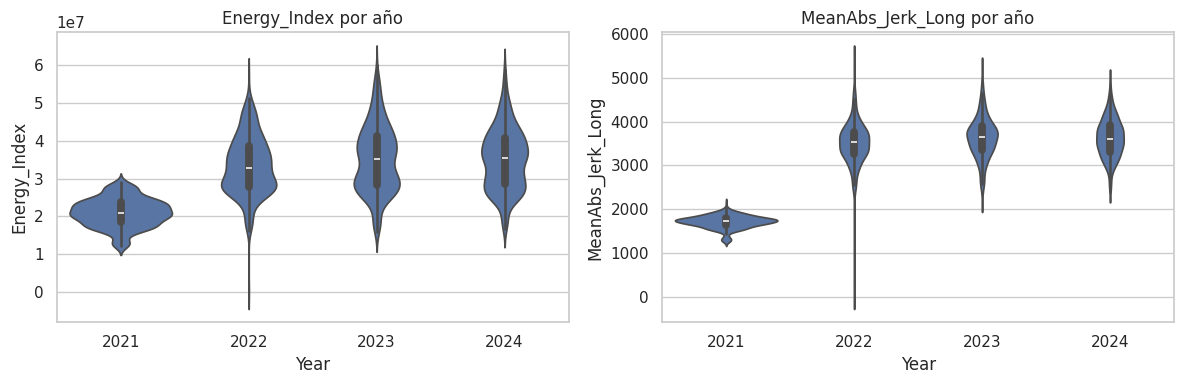

In [500]:
# Distribución de Energy_Index y jerk por año (violines)
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.violinplot(data=all_df, x='Year', y='Energy_Index', ax=ax[0], inner='box')
sns.violinplot(data=all_df, x='Year', y='MeanAbs_Jerk_Long', ax=ax[1], inner='box')
ax[0].set_title('Energy_Index por año'); ax[1].set_title('MeanAbs_Jerk_Long por año')
plt.tight_layout(); plt.show()

## PCA global multiaño (all_lap_features)

In [501]:
import pandas as pd
import json
scores_global = pd.read_csv('../feature_extraction/data/module1_ingestion/pca_scores_global.csv')
model_global = json.loads(open('../feature_extraction/data/module1_ingestion/pca_model_global.json').read())
var = model_global['explained_variance_ratio']
print('Varianza explicada:', var)
scores_global.head()

Varianza explicada: [0.24360934895090808, 0.11930103939846354, 0.09351997639486523]


Driver  LapNumber Compound  Year                 Event SessionType  LapTimeSeconds  Energy_Index  MeanAbs_Jerk_Long  MeanAbs_Jerk_Lat  \
0       1         56     HARD  2024  Abu_Dhabi_Grand_Prix           R          87.765  3.542106e+07        3724.862008        509.710210   
1       4         52     HARD  2024  Abu_Dhabi_Grand_Prix           R          87.438  3.757495e+07        3787.153473        522.932571   
2      10         30     HARD  2024  Abu_Dhabi_Grand_Prix           R          89.251  3.406765e+07        3465.595521        435.651577   
3      14         51     HARD  2024  Abu_Dhabi_Grand_Prix           R          87.948  3.580297e+07        3830.513642        484.793492   
4      16         51     HARD  2024  Abu_Dhabi_Grand_Prix           R          88.018  3.595736e+07        3788.356424        505.835864   

   Avg_Speed_mps  Brake_Aggression  Max_Lateral_g  Max_Longitudinal_g  TyreLife       PC1       PC2       PC3  
0      59.691856          0.356491     208.643351          425.452048      27.0  2.057402  1.751106 -0.991751  
1      59.549224          0.352446     294.196370          614.741784      26.0  3.117118  1.736516 -1.128789  
2      58.501401          0.344818      97.628887          385.905555      16.0  0.933474  1.584479 -0.565617  
3      59.269282          0.368075     138.679008          264.940395      15.0  1.303949  1.416303 -0.719466  
4      59.259854          0.369986     104.497668          330.602827      31.0  1.210930  1.694028 -1.138673

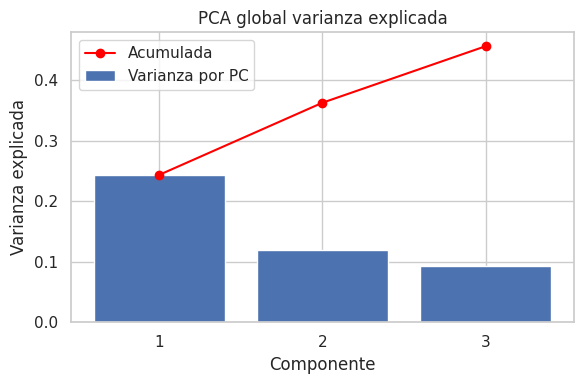

In [502]:
# Varianza explicada (barras + acumulada)
import numpy as np
import matplotlib.pyplot as plt
var = np.array(model_global['explained_variance_ratio'])
cum = var.cumsum()
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(range(1, len(var)+1), var, label='Varianza por PC')
ax.plot(range(1, len(cum)+1), cum, marker='o', color='red', label='Acumulada')
ax.set_xlabel('Componente'); ax.set_ylabel('Varianza explicada'); ax.set_title('PCA global varianza explicada')
ax.set_xticks(range(1, len(var)+1))
ax.legend(); plt.tight_layout(); plt.show()

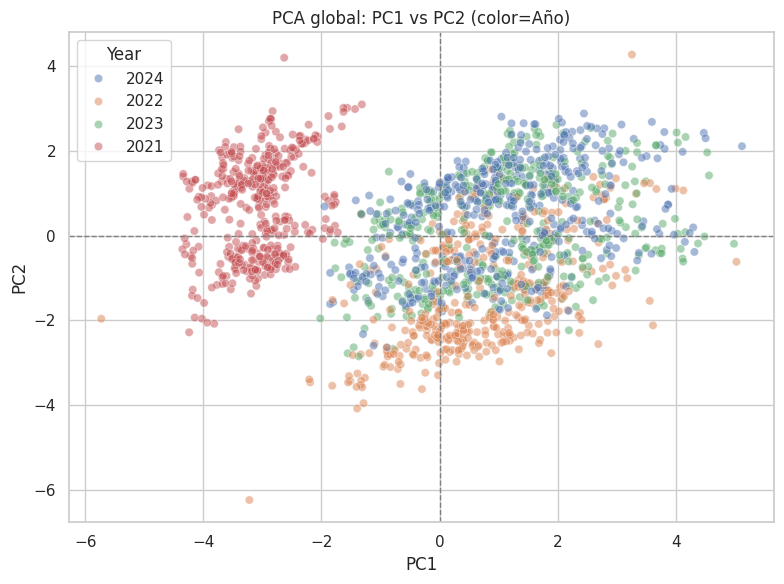

In [503]:
# PC1 vs PC2 coloreado por año
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=scores_global, x='PC1', y='PC2', hue=scores_global['Year'].astype(str), alpha=0.5, ax=ax)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('PCA global: PC1 vs PC2 (color=Año)')
plt.tight_layout(); plt.show()

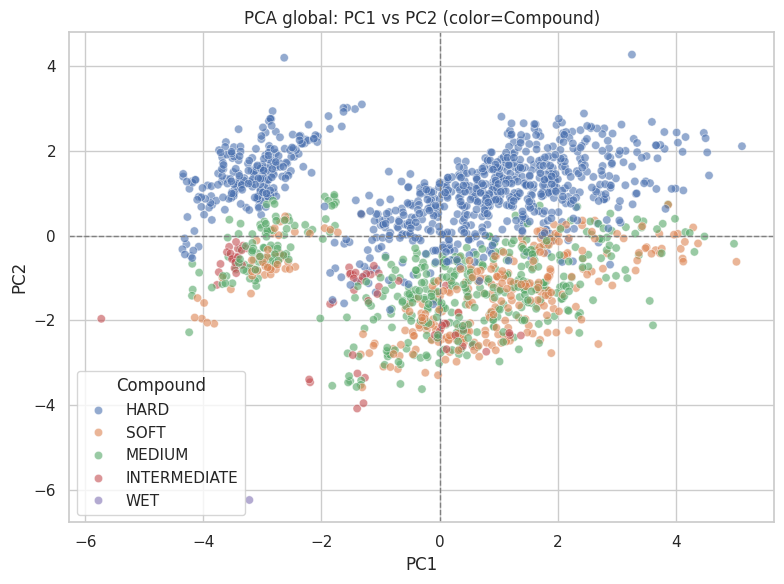

In [504]:
# PC1 vs PC2 coloreado por Compound
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=scores_global, x='PC1', y='PC2', hue='Compound', alpha=0.6, ax=ax)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('PCA global: PC1 vs PC2 (color=Compound)')
plt.tight_layout(); plt.show()

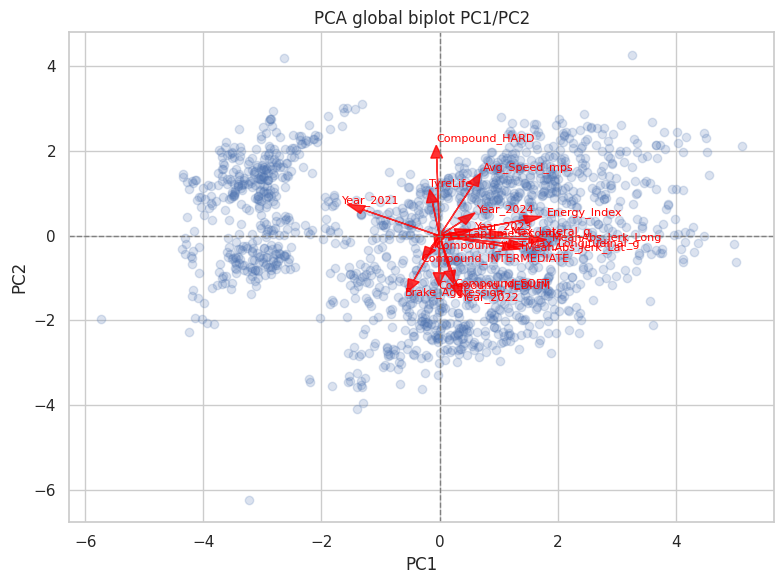

In [505]:
# Biplot 2D global (vectores de variables)
import numpy as np
loadings = pd.DataFrame(model_global['components']).T
loadings.index = model_global['feature_names']
loadings.columns = [f'PC{i+1}' for i in range(loadings.shape[1])]
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(scores_global['PC1'], scores_global['PC2'], alpha=0.2, label='Laps')
scale = 0.7 * min(scores_global['PC1'].abs().max(), scores_global['PC2'].abs().max())
for feat in loadings.index:
    xvec = loadings.loc[feat,'PC1'] * scale
    yvec = loadings.loc[feat,'PC2'] * scale
    ax.arrow(0,0,xvec,yvec,color='red',head_width=0.05*scale,length_includes_head=True,alpha=0.8)
    ax.text(xvec*1.05,yvec*1.05,feat,color='red',fontsize=8)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_title('PCA global biplot PC1/PC2')
plt.tight_layout(); plt.show()

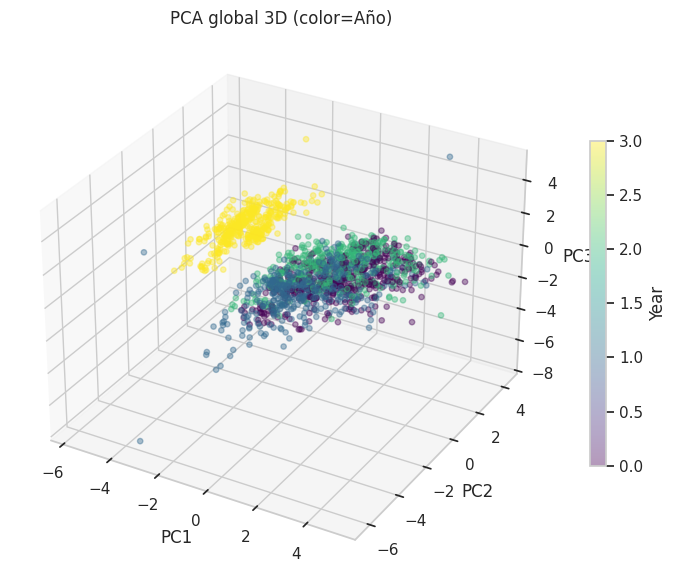

In [506]:
# PCA 3D global (PC1-PC2-PC3) coloreado por año
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
codes, labels = pd.factorize(scores_global['Year'])
sc = ax.scatter(scores_global['PC1'], scores_global['PC2'], scores_global['PC3'], c=codes, cmap='viridis', s=15, alpha=0.4)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.set_title('PCA global 3D (color=Año)')
fig.colorbar(sc, ax=ax, shrink=0.6, label='Year')
plt.tight_layout(); plt.show()

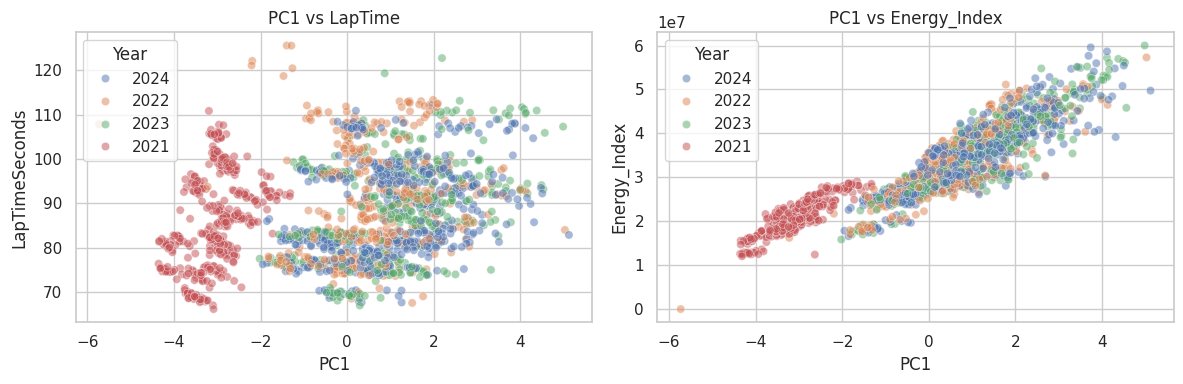

In [507]:
# PC1 vs LapTime y PC1 vs Energy para ver relación con ritmo/demanda (PCA global bruto)
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.scatterplot(data=scores_global, x='PC1', y='LapTimeSeconds', hue=scores_global['Year'].astype(str), alpha=0.5, ax=ax[0])
ax[0].set_title('PC1 vs LapTime')
sns.scatterplot(data=scores_global, x='PC1', y='Energy_Index', hue=scores_global['Year'].astype(str), alpha=0.5, ax=ax[1])
ax[1].set_title('PC1 vs Energy_Index')
plt.tight_layout(); plt.show()

## PCA global normalizado por evento

In [508]:
import pandas as pd
import json
scores_norm = pd.read_csv('../feature_extraction/data/module1_ingestion/pca_scores_global_norm.csv')
model_norm = json.loads(open('../feature_extraction/data/module1_ingestion/pca_model_global_norm.json').read())
var = model_norm['explained_variance_ratio']
print('Varianza explicada (norm):', var)
scores_norm.head()

Varianza explicada (norm): [0.23182244072617025, 0.1389799736219159, 0.12586451017222178]


Driver  LapNumber Compound  Year                 Event SessionType  LapTimeSeconds  Energy_per_m       PC1       PC2       PC3
0       1         56     HARD  2024  Abu_Dhabi_Grand_Prix           R          87.765   6761.220016  1.198468 -0.419680  2.041139
1       4         52     HARD  2024  Abu_Dhabi_Grand_Prix           R          87.438   7216.425111  2.790581  0.540144  1.856537
2      10         30     HARD  2024  Abu_Dhabi_Grand_Prix           R          89.251   6524.733479 -2.178363 -0.485941  1.224515
3      14         51     HARD  2024  Abu_Dhabi_Grand_Prix           R          87.948   6868.524273  0.171875 -0.237932  1.195114
4      16         51     HARD  2024  Abu_Dhabi_Grand_Prix           R          88.018   6893.752394  0.146530  0.087543  1.669642

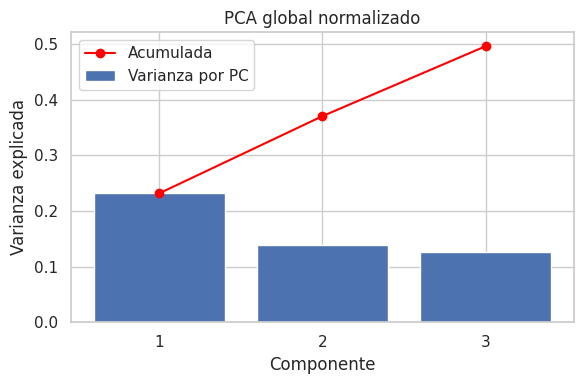

In [509]:
# Varianza explicada normalizado
import numpy as np
import matplotlib.pyplot as plt
var = np.array(model_norm['explained_variance_ratio']); cum = var.cumsum()
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(range(1, len(var)+1), var, label='Varianza por PC')
ax.plot(range(1, len(cum)+1), cum, marker='o', color='red', label='Acumulada')
ax.set_xlabel('Componente'); ax.set_ylabel('Varianza explicada'); ax.set_title('PCA global normalizado')
ax.set_xticks(range(1, len(var)+1))
ax.legend(); plt.tight_layout(); plt.show()

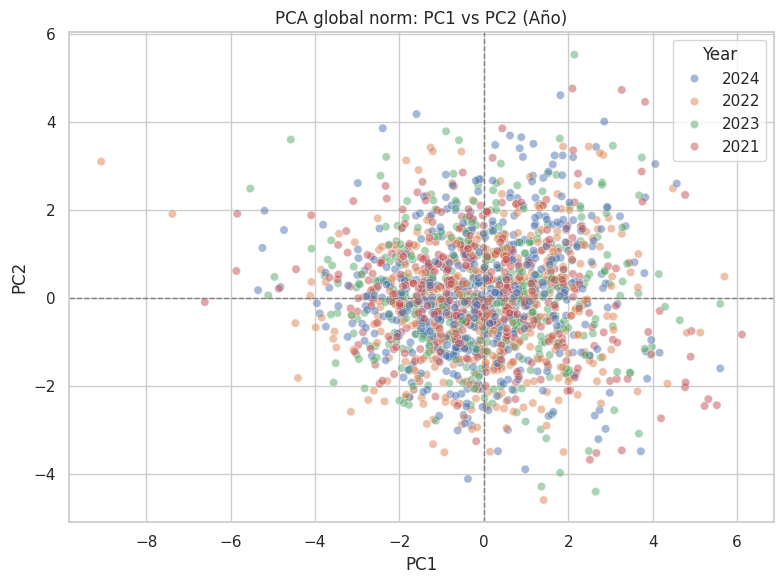

In [510]:
# PC1 vs PC2 (norm) coloreado por año
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=scores_norm, x='PC1', y='PC2', hue=scores_norm['Year'].astype(str), alpha=0.5, ax=ax)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('PCA global norm: PC1 vs PC2 (Año)')
plt.tight_layout(); plt.show()

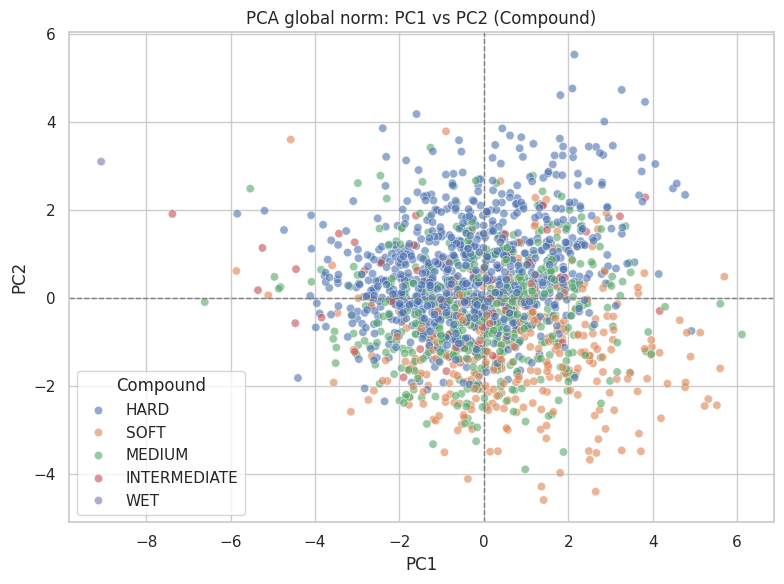

In [511]:
# PC1 vs PC2 (norm) coloreado por Compound
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=scores_norm, x='PC1', y='PC2', hue='Compound', alpha=0.6, ax=ax)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('PCA global norm: PC1 vs PC2 (Compound)')
plt.tight_layout(); plt.show()

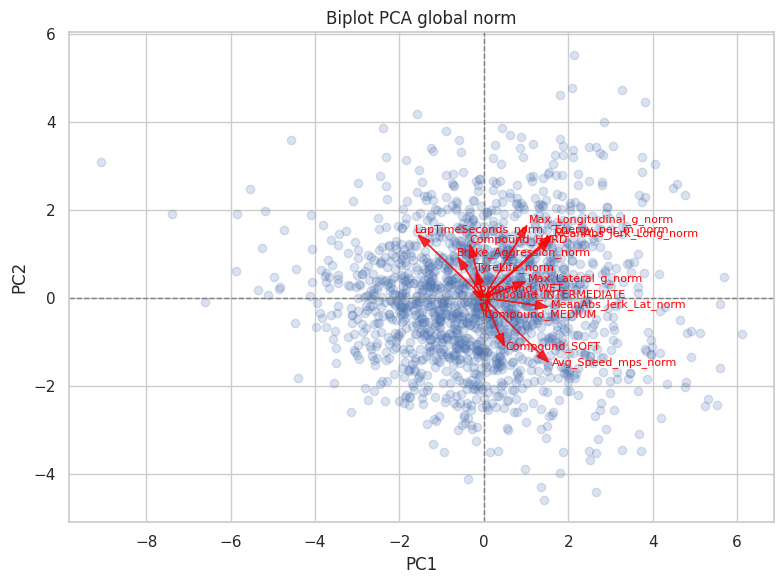

In [512]:
# Biplot 2D (norm)
import numpy as np
load_df = pd.DataFrame(model_norm['components']).T
load_df.index = model_norm['feature_names']
load_df.columns = [f'PC{i+1}' for i in range(load_df.shape[1])]
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(scores_norm['PC1'], scores_norm['PC2'], alpha=0.2, label='Laps')
scale = 0.7 * min(scores_norm['PC1'].abs().max(), scores_norm['PC2'].abs().max())
for feat in load_df.index:
    xvec = load_df.loc[feat,'PC1'] * scale
    yvec = load_df.loc[feat,'PC2'] * scale
    ax.arrow(0,0,xvec,yvec,color='red',head_width=0.05*scale,length_includes_head=True,alpha=0.8)
    ax.text(xvec*1.05,yvec*1.05,feat,color='red',fontsize=8)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_title('Biplot PCA global norm')
plt.tight_layout(); plt.show()

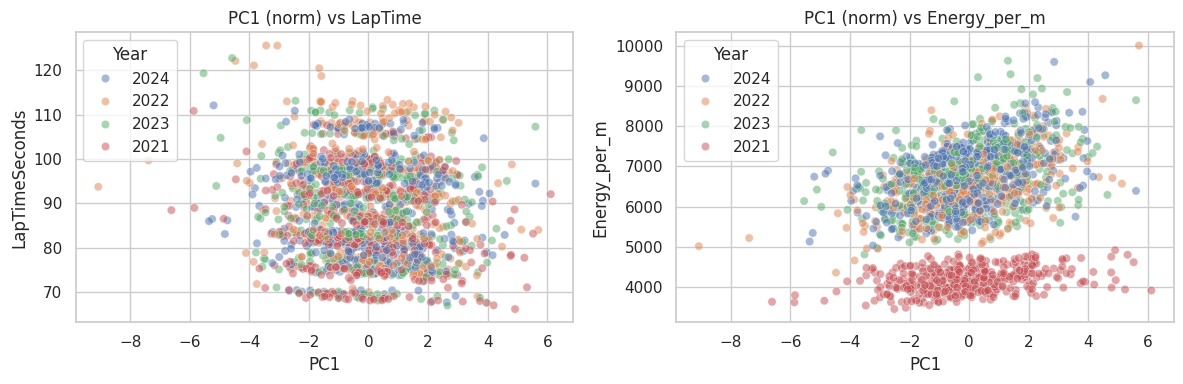

In [513]:
# PC1 vs LapTime y PC1 vs Energy_per_m (PCA normalizado)
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.scatterplot(data=scores_norm, x='PC1', y='LapTimeSeconds', hue=scores_norm['Year'].astype(str), alpha=0.5, ax=ax[0])
ax[0].set_title('PC1 (norm) vs LapTime')
sns.scatterplot(data=scores_norm, x='PC1', y='Energy_per_m', hue=scores_norm['Year'].astype(str), alpha=0.5, ax=ax[1])
ax[1].set_title('PC1 (norm) vs Energy_per_m')
plt.tight_layout(); plt.show()

## Análisis de errores y métricas (Módulo 4)

In [514]:
# Cargar métricas y predicciones con meta (Year, Compound, etc.)
import json
metrics = json.loads(open(f"{base}/model_metrics_module4.json").read())
preds = pd.read_csv(f"{base}/val_predictions_module4.csv")
metrics_for_df = {k:v for k,v in metrics.items() if k != 'best_model'}
display(pd.DataFrame(metrics_for_df).T)
preds.head()

MAE      RMSE        R2
RandomForest      0.504447  0.930468  0.092048
GradientBoosting  0.568287  0.897282  0.155660
Lasso             0.161946  0.182602  0.965032

y_true     y_pred
0  92.608  92.915579
1  95.065  95.170421
2  94.722  94.846257
3  94.735  94.845528

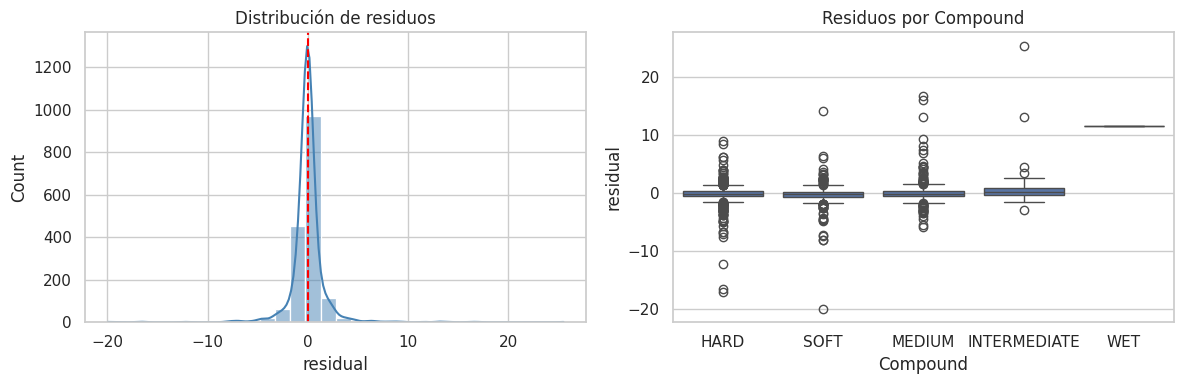

In [515]:
# Residuales (y_true - y_pred)
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
base = Path('..')/'feature_extraction'/'data'/'module1_ingestion'
preds = pd.read_csv(base/'val_predictions_module4.csv')
preds['residual'] = preds['y_true'] - preds['y_pred']
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(preds['residual'], bins=30, kde=True, ax=ax[0], color='steelblue')
ax[0].axvline(0, color='red', linestyle='--'); ax[0].set_title('Distribución de residuos')
if 'Compound' in preds.columns:
    sns.boxplot(data=preds, x='Compound', y='residual', ax=ax[1])
    ax[1].set_title('Residuos por Compound')
else:
    ax[1].text(0.5,0.5,'Compound no disponible en preds', ha='center'); ax[1].axis('off')
plt.tight_layout(); plt.show()


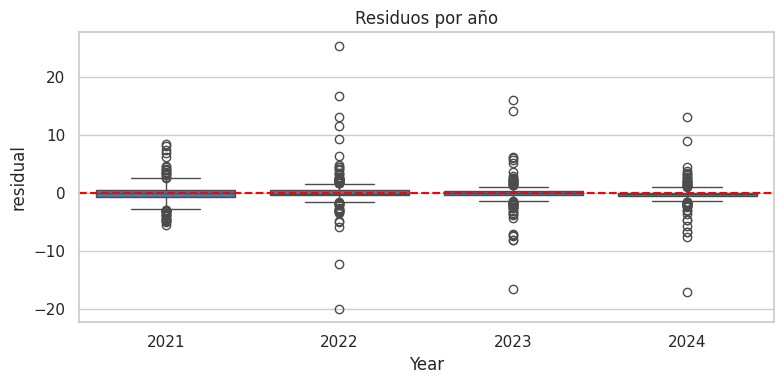

In [516]:
# Residuos por año
import seaborn as sns, matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,4))
if 'Year' in preds.columns:
    sns.boxplot(data=preds, x='Year', y='residual', ax=ax)
    ax.axhline(0, color='red', linestyle='--'); ax.set_title('Residuos por año')
else:
    ax.text(0.5,0.5,'Year no disponible en preds', ha='center')
    ax.axis('off')
plt.tight_layout(); plt.show()


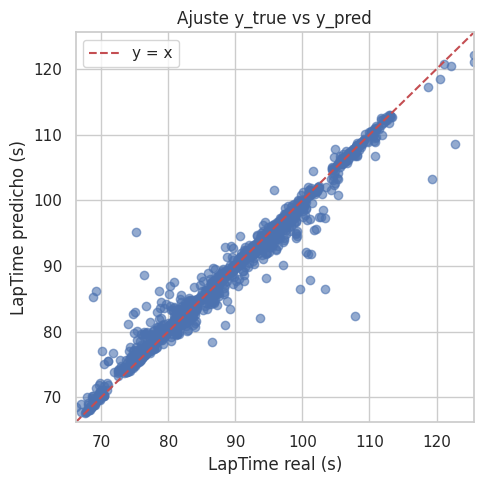

In [517]:
# y_true vs y_pred del mejor modelo
import matplotlib.pyplot as plt
import numpy as np
# Suponemos que 'preds' ya está cargado en el entorno (ver celdas anteriores)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(preds['y_true'], preds['y_pred'], alpha=0.6)
lims = [
    float(min(preds['y_true'].min(), preds['y_pred'].min())),
    float(max(preds['y_true'].max(), preds['y_pred'].max()))
]
ax.plot(lims, lims, 'r--', label='y = x')
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel('LapTime real (s)'); ax.set_ylabel('LapTime predicho (s)')
ax.legend(); ax.set_title('Ajuste y_true vs y_pred')
plt.tight_layout(); plt.show()


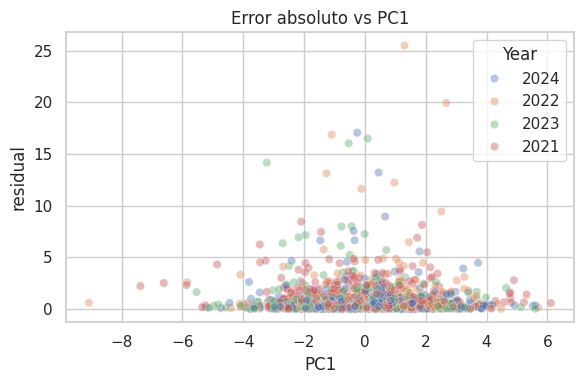

In [518]:
# Error absoluto vs PC1 (normalizado) si está presente
import seaborn as sns, matplotlib.pyplot as plt
if 'PC1' in preds.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.scatterplot(data=preds, x='PC1', y=preds['residual'].abs(), hue=preds.get('Year', pd.Series(['NA']*len(preds))).astype(str), alpha=0.4)
    ax.set_title('Error absoluto vs PC1')
    plt.tight_layout(); plt.show()
else:
    print('PC1 no disponible en preds')


/tmp/ipykernel_62286/999166294.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


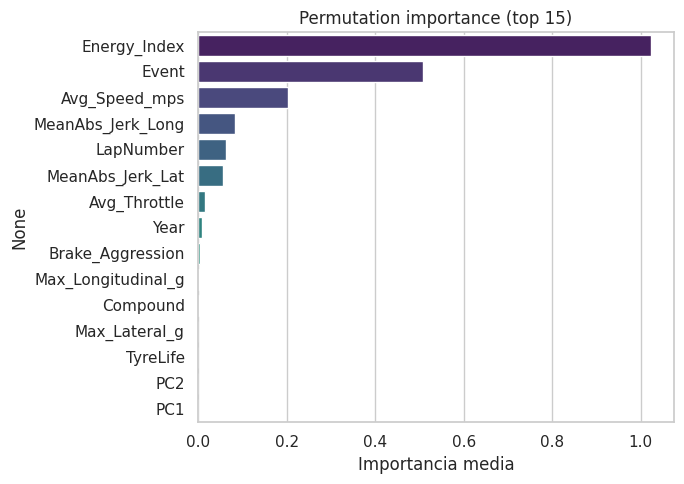

In [519]:
# Importancias de features vía permutation importance (si best_model es árbol)
import joblib, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.inspection import permutation_importance
base = Path('..')/'feature_extraction'/'data'/'module1_ingestion'
try:
    pipe = joblib.load(base/'best_model_module4.pkl')
    X = pd.read_csv(base/'val_predictions_module4.csv').drop(columns=['y_true','y_pred','fold_order'], errors='ignore')
    y = pd.read_csv(base/'val_predictions_module4.csv')['y_true']
    result = permutation_importance(pipe, X, y, n_repeats=20, random_state=42, n_jobs=-1)
    importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False).head(15)
    plt.figure(figsize=(7,5))
    sns.barplot(x=importances.values, y=importances.index, palette='viridis')
    plt.title('Permutation importance (top 15)'); plt.xlabel('Importancia media'); plt.tight_layout(); plt.show()
except Exception as e:
    print('No se pudo calcular importancias:', e)


## Exploración Métricas Modelos Entrenado

Mejor modelo: RandomForest {'name': 'RandomForest', 'MAE_mean': 0.8821757933681846, 'RMSE_mean': 1.875796942759574, 'R2_mean': 0.9704364694357384}


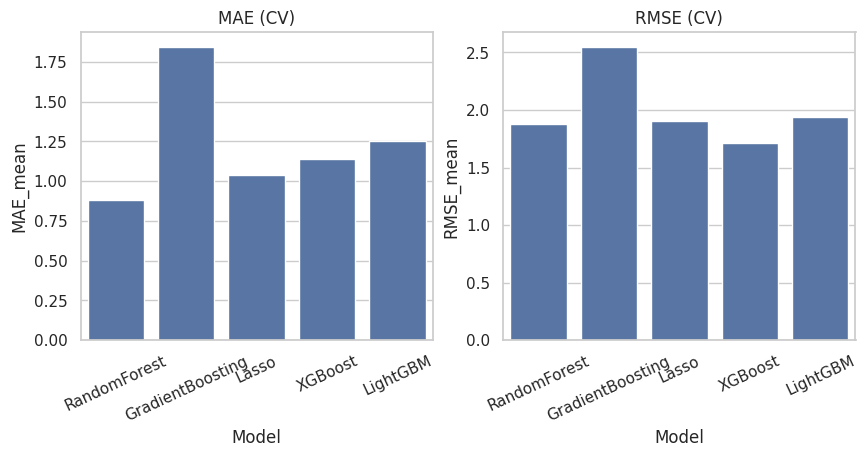

In [520]:
import json, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

mpath = Path("../feature_extraction/data/module1_ingestion/model_metrics_module4.json")
metrics = json.loads(mpath.read_text())
best = metrics.pop("best_model")
mdf = pd.DataFrame(metrics).T.astype(float).reset_index().rename(columns={"index":"Model"})
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(data=mdf, x="Model", y="MAE_mean", ax=ax[0]); ax[0].set_title("MAE (CV)")
sns.barplot(data=mdf, x="Model", y="RMSE_mean", ax=ax[1]); ax[1].set_title("RMSE (CV)")
for a in ax: a.tick_params(axis='x', rotation=25)
print("Mejor modelo:", best["name"], best)


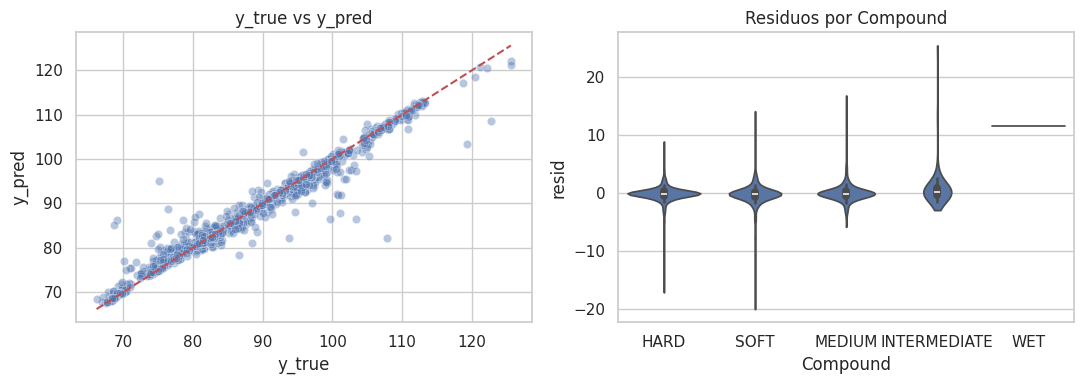

In [521]:
preds = pd.read_csv("../feature_extraction/data/module1_ingestion/val_predictions_module4.csv")
preds["resid"] = preds["y_true"] - preds["y_pred"]
fig, ax = plt.subplots(1,2, figsize=(11,4))
sns.scatterplot(data=preds, x="y_true", y="y_pred", alpha=0.4, ax=ax[0])
ax[0].plot([preds.y_true.min(), preds.y_true.max()],
           [preds.y_true.min(), preds.y_true.max()], 'r--'); ax[0].set_title("y_true vs y_pred")
sns.violinplot(data=preds, x="Compound", y="resid", cut=0, ax=ax[1])
ax[1].set_title("Residuos por Compound"); plt.tight_layout()


/tmp/ipykernel_62286/1540297554.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_abs, y="feature", x="mean_abs", palette="mako")


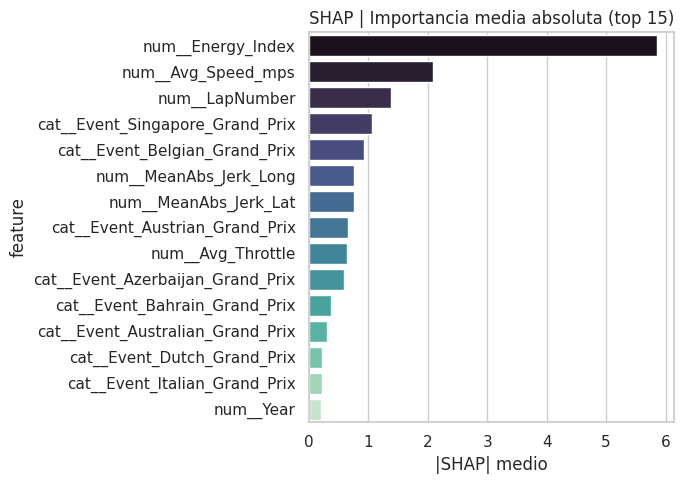

In [522]:
from pathlib import Path
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
shap_dir = Path("../feature_extraction/data/module1_ingestion/shap")
if shap_dir.exists():
    mean_abs_path = shap_dir/"shap_mean_abs.csv"
    if mean_abs_path.exists():
        mean_abs = pd.read_csv(mean_abs_path, header=None, names=["feature","mean_abs"])
        mean_abs = mean_abs.sort_values("mean_abs", ascending=False).head(15)
        plt.figure(figsize=(7,5))
        sns.barplot(data=mean_abs, y="feature", x="mean_abs", palette="mako")
        plt.title("SHAP | Importancia media absoluta (top 15)"); plt.xlabel("|SHAP| medio")
        plt.tight_layout(); plt.show()
    else:
        print("No se encontró shap_mean_abs.csv")
else:
    print("Carpeta SHAP no encontrada; ejecuta module4_modeling.py con shap instalado.")


Leído con pyarrow (fallback)


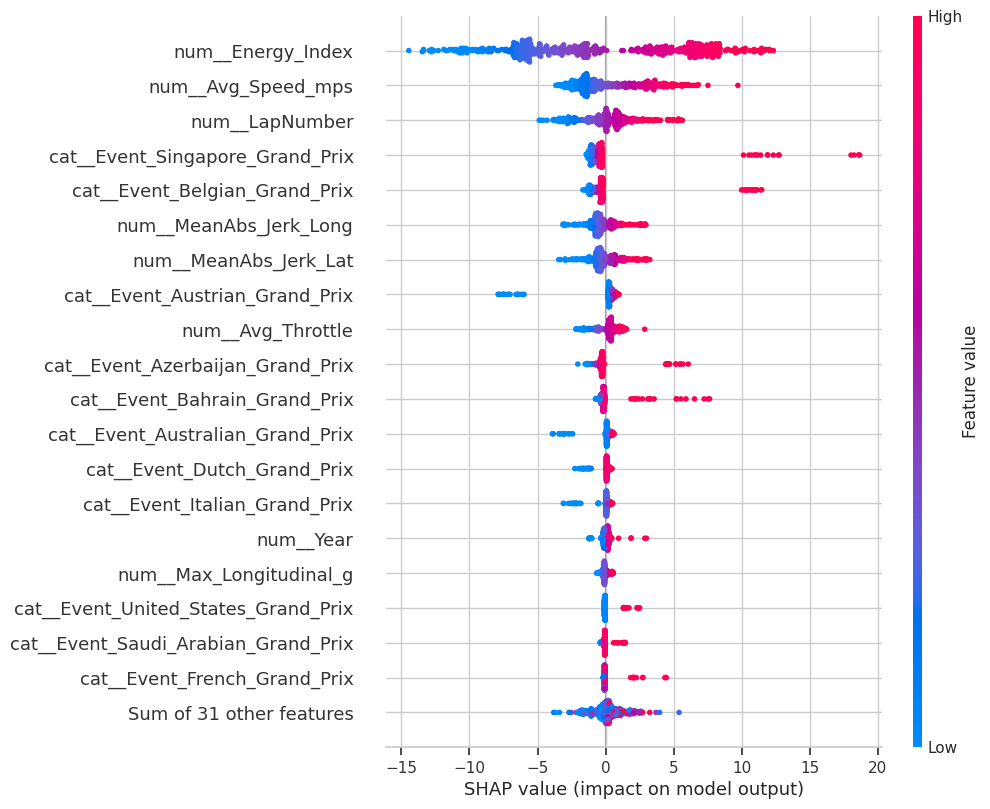

In [523]:
import pandas as pd, numpy as np, shap
from pathlib import Path
shap_dir = Path("../feature_extraction/data/module1_ingestion/shap")
val_path = shap_dir/"shap_values.parquet"
fname_path = shap_dir/"shap_feature_names.csv"
if val_path.exists():
    shap_vals = None
    try:
        shap_vals = pd.read_parquet(val_path)
    except Exception as e:
        try:
            import pyarrow.parquet as pq
            table = pq.read_table(val_path)
            shap_vals = table.to_pandas()
            print('Leído con pyarrow (fallback)')
        except Exception as ee:
            print('No se pudo leer shap_values.parquet:', ee)
    if shap_vals is not None:
        feature_names = fname_path.read_text().splitlines() if fname_path.exists() else [f'f{i}' for i in range(shap_vals.shape[1])]
        expl = shap.Explanation(values=shap_vals.values,
                                 base_values=np.zeros(len(shap_vals)),
                                 data=shap_vals.values,
                                 feature_names=feature_names)
        shap.plots.beeswarm(expl, max_display=20)
    else:
        print('Sin datos SHAP para graficar')
else:
    print('No se encontró shap_values.parquet; vuelve a correr module4_modeling.py con shap instalado.')


### Evaluación modelos (K-Fold CV)
Usamos las métricas promedio de `feature_extraction/data/module1_ingestion/model_metrics_module4.json` y comparamos los modelos entrenados en el pipeline global (features originales + PC1-3 normalizados).

Mejor modelo: {'name': 'RandomForest', 'MAE_mean': 0.8821757933681846, 'RMSE_mean': 1.875796942759574, 'R2_mean': 0.9704364694357384}


/tmp/ipykernel_62286/1660620170.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mdf, x='Model', y='MAE_mean', ax=ax[0], palette='crest')
/tmp/ipykernel_62286/1660620170.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mdf, x='Model', y='RMSE_mean', ax=ax[1], palette='flare')


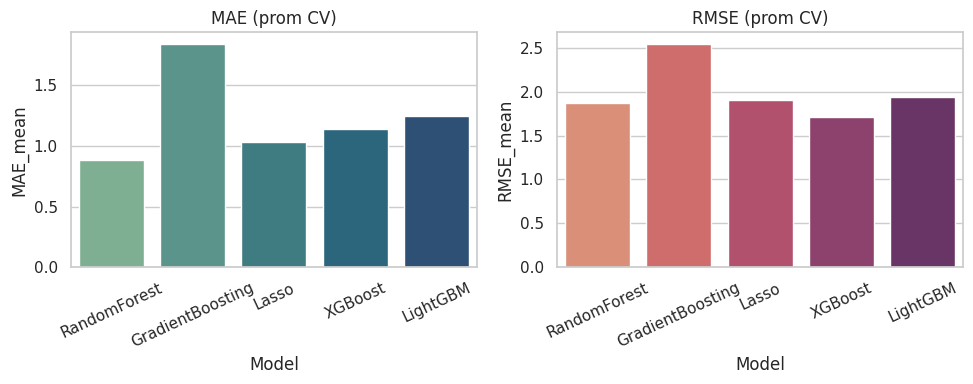

In [524]:
# === Modeling metrics CV ===
import json, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
sns.set_theme(style='whitegrid')
mpath = Path('..')/ 'feature_extraction' / 'data' / 'module1_ingestion' / 'model_metrics_module4.json'
metrics = json.loads(mpath.read_text())
best = metrics.pop('best_model', None)
mdf = pd.DataFrame(metrics).T.astype(float).reset_index().rename(columns={'index':'Model'})
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(data=mdf, x='Model', y='MAE_mean', ax=ax[0], palette='crest')
ax[0].set_title('MAE (prom CV)'); ax[0].tick_params(axis='x', rotation=25)
sns.barplot(data=mdf, x='Model', y='RMSE_mean', ax=ax[1], palette='flare')
ax[1].set_title('RMSE (prom CV)'); ax[1].tick_params(axis='x', rotation=25)
plt.tight_layout()
print('Mejor modelo:', best)


### Residuos y ajuste del mejor modelo
Usamos `val_predictions_module4.csv` (mezcla de folds) para revisar sesgo y dispersión por año/compound.

/tmp/ipykernel_62286/1027708275.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=preds, x='Year', y='resid', ax=ax[2], palette='pastel')


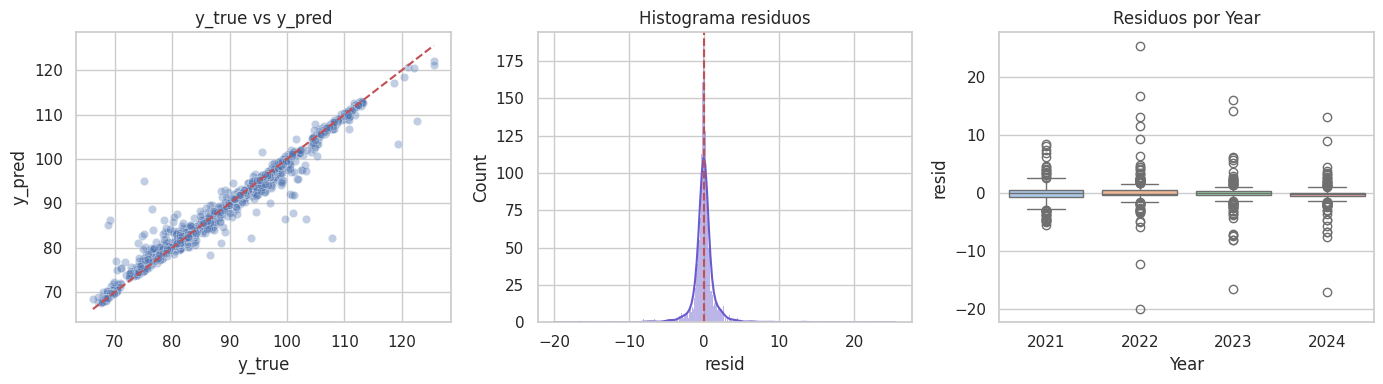

In [525]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
preds = pd.read_csv(Path('..')/'feature_extraction'/'data'/'module1_ingestion'/'val_predictions_module4.csv')
preds['resid'] = preds['y_true'] - preds['y_pred']
fig, ax = plt.subplots(1,3, figsize=(14,4))
# y_true vs y_pred
sns.scatterplot(data=preds, x='y_true', y='y_pred', alpha=0.35, ax=ax[0])
lims = [preds[['y_true','y_pred']].min().min(), preds[['y_true','y_pred']].max().max()]
ax[0].plot(lims, lims, 'r--'); ax[0].set_title('y_true vs y_pred'); ax[0].set_xlabel('y_true'); ax[0].set_ylabel('y_pred')
# Hist residuos
sns.histplot(preds['resid'], kde=True, ax=ax[1], color='slateblue'); ax[1].axvline(0, color='r', ls='--'); ax[1].set_title('Histograma residuos')
# Box por Year (si existe)
if 'Year' in preds.columns:
    sns.boxplot(data=preds, x='Year', y='resid', ax=ax[2], palette='pastel')
    ax[2].set_title('Residuos por Year')
plt.tight_layout()


### Importancia de variables (SHAP)
Si existen los archivos en `data/module1_ingestion/shap/`, graficamos barras de importancia y beeswarm. Si no, esta celda avisará.

Leído con pyarrow (fallback)


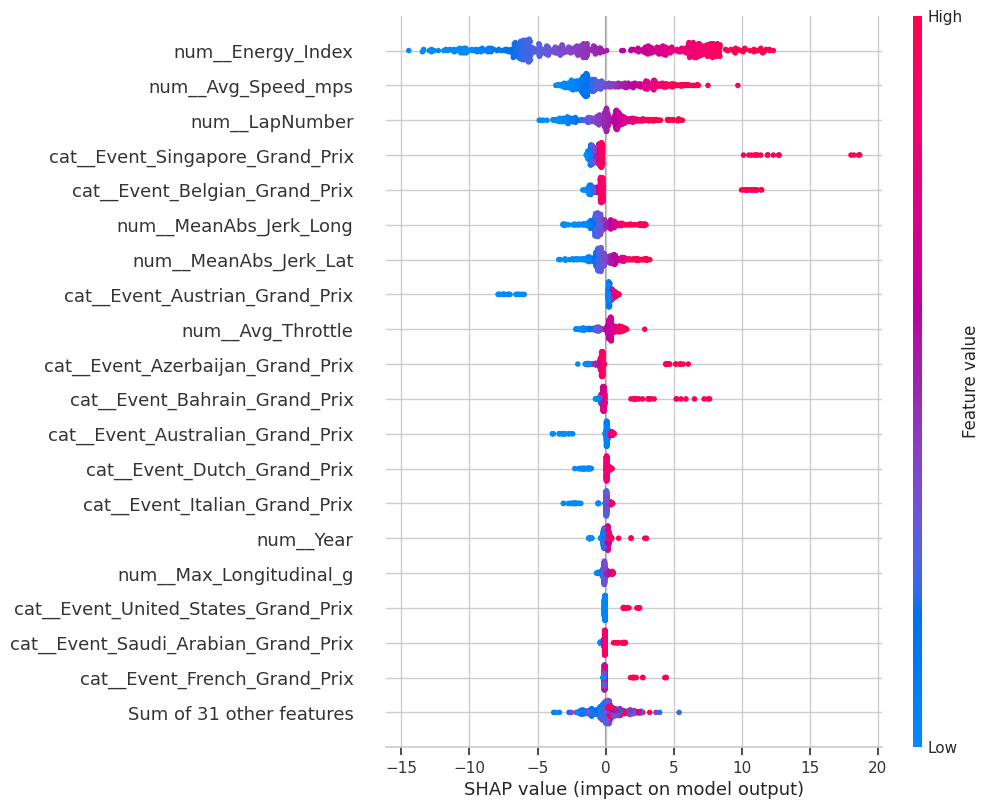

In [526]:
import pandas as pd, numpy as np, shap
from pathlib import Path
shap_dir = Path("../feature_extraction/data/module1_ingestion/shap")
val_path = shap_dir/"shap_values.parquet"
fname_path = shap_dir/"shap_feature_names.csv"
if val_path.exists():
    shap_vals = None
    try:
        shap_vals = pd.read_parquet(val_path)
    except Exception as e:
        try:
            import pyarrow.parquet as pq
            table = pq.read_table(val_path)
            shap_vals = table.to_pandas()
            print('Leído con pyarrow (fallback)')
        except Exception as ee:
            print('No se pudo leer shap_values.parquet:', ee)
    if shap_vals is not None:
        feature_names = fname_path.read_text().splitlines() if fname_path.exists() else [f'f{i}' for i in range(shap_vals.shape[1])]
        expl = shap.Explanation(values=shap_vals.values,
                                 base_values=np.zeros(len(shap_vals)),
                                 data=shap_vals.values,
                                 feature_names=feature_names)
        shap.plots.beeswarm(expl, max_display=20)
    else:
        print('Sin datos SHAP para graficar')
else:
    print('No se encontró shap_values.parquet; vuelve a correr module4_modeling.py con shap instalado.')
